# 📦 Data Loading & Setup

In [ ]:
# Cell 1 - Enhanced Imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ML and preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support

# Association rules
from mlxtend.frequent_patterns import apriori, association_rules

# Graph and visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Utilities
from itertools import combinations
import random
from datetime import datetime
import json
import pickle
import joblib

print("All imports loaded successfully")

All imports loaded successfully


In [2]:
# MLflow availability flag
try:
    import mlflow
    MLFLOW_AVAILABLE = True
except Exception:
    MLFLOW_AVAILABLE = False

In [3]:
# Cell 2 - Enhanced Synthetic Data with Diversity
try:
    data = pd.read_csv(
        "ECommerceOrderBundles.csv",
        dtype={
            "user_location": "int8",
            "platform": "int8",
            "category": "int8",
            "quantity": "int16"
        },
        parse_dates=["order_date"]
    )
    print(f"Data loaded: {data.shape[0]} rows, {data.shape[1]} columns")
    
    # Validate user_location range (signed int8)
    assert data['user_location'].between(-128, 127).all(), \
        f"user_location values out of int8 range: {data['user_location'].min()} to {data['user_location'].max()}"
    
except FileNotFoundError as e:
    print(f"Warning: CSV file not found: {e}")
    print("Creating realistic synthetic data for demonstration...")
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Create realistic synthetic data
    n_rows = 5000
    
    # Generate diverse order IDs (about 1266 unique orders like real data)
    n_unique_orders = 1266
    order_ids = [f"order_{i:04d}" for i in range(n_unique_orders)]
    data_order_ids = np.random.choice(order_ids, n_rows)
    
    # Generate diverse user IDs (about 712 unique users like real data)
    n_unique_users = 712
    user_ids = [f"user_{i:04d}" for i in range(n_unique_users)]
    data_user_ids = np.random.choice(user_ids, n_rows)
    
    # Generate diverse product IDs (300 unique products like real data)
    n_unique_products = 300
    product_ids = [f"product_{i:04d}" for i in range(n_unique_products)]
    data_product_ids = np.random.choice(product_ids, n_rows)
    
    # Create realistic data
    data = pd.DataFrame({
        'order_id': data_order_ids,
        'user_id': data_user_ids,
        'user_age': np.random.randint(18, 65, n_rows),
        'user_location': np.random.randint(0, 100, n_rows).astype(np.int8),
        'order_date': pd.to_datetime(np.random.choice(pd.date_range('2023-01-01', '2025-07-08', periods=100), n_rows)),
        'platform': np.random.choice([0, 1, 2], n_rows, p=[0.7, 0.2, 0.1]).astype(np.int8),
        'product_id': data_product_ids,
        'product_name': ['Product_' + str(i % 50) for i in range(n_rows)],
        'category': np.random.randint(0, 12, n_rows).astype(np.int8),
        'price': np.round(np.random.uniform(5, 300, n_rows), 2),
        'brand': np.random.choice(['Brand_A', 'Brand_B', 'Brand_C', 'Brand_D', 'Brand_E', 
                                  'Tanishq', 'Lakme', 'Nivia', 'Himalaya', 'Prestige'], n_rows),
        'features': [f"Feature_{i%10}_v{i%5}" for i in range(n_rows)],
        'quantity': np.random.randint(1, 5, n_rows).astype(np.int16),
        'item_total': np.round(np.random.uniform(10, 500, n_rows), 2),
        'co_purchase_count': np.random.randint(100, 2000, n_rows)
    })
    
    # Ensure item_total = price * quantity
    data['item_total'] = np.round(data['price'] * data['quantity'], 2)
    
    print(f"Created realistic synthetic data: {data.shape[0]} rows, {data.shape[1]} columns")
    print(f"Stats: {data['order_id'].nunique():,} unique orders, "
          f"{data['user_id'].nunique():,} unique users, "
          f"{data['product_id'].nunique():,} unique products")

data.head()

Data loaded: 5000 rows, 15 columns


,order_id,user_id,user_age,user_location,order_date,platform,product_id,product_name,category,price,brand,features,quantity,item_total,co_purchase_count
0,a4b88a2a-42fa-45b6-be05-4941f5b403a4,Tamara Levine,52,0,2024-07-16 03:28:07,0,56064e4a-ad4d-4831-8820-92a1e9ba4c4c,Mangalsutra,0,15.240,Tanishq,"Silver, studded, lightweight",1,15.240,525
1,a4b88a2a-42fa-45b6-be05-4941f5b403a4,Tamara Levine,52,0,2024-07-16 03:28:07,0,bdf375f2-d1ff-4654-b4d2-ba674aac43cc,Anklets,0,62.360,Lakme,"22K, traditional design, 20g",2,124.720,702
2,a4b88a2a-42fa-45b6-be05-4941f5b403a4,Tamara Levine,52,0,2024-07-16 03:28:07,0,0fa624d3-e534-4f1b-af1c-2b9733200f07,Mangalsutra,0,62.944,Nivia,"Silver, studded, lightweight",3,188.832,329
3,6c9e215f-89d8-4bd7-b29d-0b276ea9c75f,Anna Torres,32,1,2024-10-26 02:54:16,0,008585e6-94e3-4c54-a884-f972b965e688,Water Purifier,1,280.150,AmarChitraKatha,"RO+UV, 7L storage, wall-mounted",2,560.300,164
4,6c9e215f-89d8-4bd7-b29d-0b276ea9c75f,Anna Torres,32,1,2024-10-26 02:54:16,0,ca21b8e1-6116-40ae-a58a-8847577f9cf7,Pressure Cooker,1,243.090,Himalaya,"3 burners, stainless steel, auto-ignition",1,243.090,164


In [4]:
# Cell 3 - EDA
print("="*50)
print("DATASET EXPLORATION")
print("="*50)

print(f"Dataset Shape: {data.shape}")

print(f"\nMissing Values:")
print(data.isnull().sum())

print(f"\nData Types:")
print(data.dtypes)

print(f"\nBasic Statistics:")
print(f"Number of unique orders: {data['order_id'].nunique():,}")
print(f"Number of unique users: {data['user_id'].nunique():,}")
print(f"Number of unique products: {data['product_id'].nunique():,}")

# Format dates properly
if 'order_date' in data.columns:
    min_date = data['order_date'].min().strftime('%Y-%m-%d %H:%M')
    max_date = data['order_date'].max().strftime('%Y-%m-%d %H:%M')
    print(f"Date range: {min_date} to {max_date}")

print(f"\nOrder size distribution:")
order_sizes = data.groupby('order_id').size()
print(f"Min items per order: {order_sizes.min()}")
print(f"Max items per order: {order_sizes.max()}")
print(f"Avg items per order: {order_sizes.mean():.2f}")

# Check if using synthetic data
if len(data) < 100 or data['order_id'].nunique() < 10:
    print("\n⚠️  NOTE: Using synthetic/demo data - statistics may differ from production")

DATASET EXPLORATION
Dataset Shape: (5000, 15)

Missing Values:
order_id             0
user_id              0
user_age             0
user_location        0
order_date           0
platform             0
product_id           0
product_name         0
category             0
price                0
brand                0
features             0
quantity             0
item_total           0
co_purchase_count    0
dtype: int64

Data Types:
order_id                     object
user_id                      object
user_age                      int64
user_location                  int8
order_date           datetime64[ns]
platform                       int8
product_id                   object
product_name                 object
category                       int8
price                       float64
brand                        object
features                     object
quantity                      int16
item_total                  float64
co_purchase_count             int64
dtype: object

Basic Stati

In [42]:
# === ARTIFACT: products_df ===

products_df = (
    data[
        [
            "product_id",
            "product_name",
            "category",
            "brand",
            "price",
            "features"
        ]
    ]
    .drop_duplicates()
    .set_index("product_id")
)

print("✓ products_df created:", products_df.shape)


✓ products_df created: (890, 5)


# 🛠️ Data Preprocessing

In [5]:
# Cell 4 - Column Definitions
numeric_cols = ['user_age', 'price', 'quantity', 'co_purchase_count']
categorical_cols = ['user_location', 'platform', 'category', 'brand']
required_cols = numeric_cols + categorical_cols + ['order_id', 'user_id', 'product_id', 'product_name','item_total', 'features']

### Verifying columns

In [6]:
# Cell 5 - Validate Required Columns
missing_cols = [col for col in required_cols if col not in data.columns]
if missing_cols:
    print(f"Error: Missing columns: {missing_cols}")
    raise ValueError("Dataset is missing required columns")
else:
    print("All done")

All done


### Encodes categorical columns (if not already encoded)

In [7]:
# Cell 6 - Consistent Categorical Encoding
print("Categorical Variables Summary:")
for col in categorical_cols:
    if col in data.columns:
        unique_vals = data[col].nunique()
        print(f"- {col}: {unique_vals} unique values")
        if unique_vals < 20:
            print(f"  Values: {sorted(data[col].astype(str).unique()[:10])}{'...' if unique_vals > 10 else ''}")

# Store category mappings with consistent encoding
category_mapping = {}
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Convert to string for consistent encoding
    data[f'{col}_encoded'] = le.fit_transform(data[col].astype(str).fillna('Unknown'))
    label_encoders[col] = le
    category_mapping[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    
    # For downstream use, create decoded versions
    data[f'{col}_original'] = data[col]
    
    # Save encoders for deployment
    if MLFLOW_AVAILABLE:
        try:
            encoder_path = f'{col}_encoder.pkl'
            joblib.dump(le, encoder_path)
            if mlflow.active_run():
                mlflow.log_artifact(encoder_path)
        except:
            pass

print("\n✓ Encoding complete. Encoders saved for deployment.")

Categorical Variables Summary:
- user_location: 256 unique values
- platform: 3 unique values
  Values: ['0', '1', '2']
- category: 12 unique values
  Values: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']...
- brand: 12 unique values
  Values: ['AmarChitraKatha', 'Castrol', 'Funskool', 'Godrej', 'Himalaya', 'Lakme', 'Nivia', 'Prestige', 'Samsung', 'Tanishq']...

✓ Encoding complete. Encoders saved for deployment.


In [43]:
# === ARTIFACT: label_encoders ===

label_encoders = {
    "brand": joblib.load("brand_encoder.pkl"),
    "category": joblib.load("category_encoder.pkl"),
    "platform": joblib.load("platform_encoder.pkl"),
    "user_location": joblib.load("user_location_encoder.pkl"),
}

print("✓ label_encoders packaged")


✓ label_encoders packaged


### Ensuring numeric columns are numeric

In [8]:
#cell :7
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

### Checking for missing values before dropping

In [9]:
#cell :8
data[numeric_cols] = data[numeric_cols].fillna(0)
data['features'] = data['features'].fillna('')

In [10]:
#cell :9
print("Missing values before dropping:")
print(data[required_cols].isna().sum())

Missing values before dropping:
user_age             0
price                0
quantity             0
co_purchase_count    0
user_location        0
platform             0
category             0
brand                0
order_id             0
user_id              0
product_id           0
product_name         0
item_total           0
features             0
dtype: int64


### Drop rows with missing values in critical column

In [11]:
# Fixed Cell 10 - Better Missing Value Handling
# Add item_total to required columns
required_cols = numeric_cols + categorical_cols + ['order_id', 'user_id', 
                                                  'product_id', 'product_name', 
                                                  'item_total', 'features']

original_len = len(data)

# Check for critical columns that shouldn't be missing
critical_cols = ['order_id', 'product_id', 'user_id', 'price']
data = data.dropna(subset=critical_cols)

# Fill other missing values appropriately
for col in data.columns:
    if col not in critical_cols and data[col].isnull().any():
        if col in numeric_cols:
            data[col] = data[col].fillna(data[col].median() if data[col].dtype in ['float64', 'int64'] else 0)
        elif col == 'features':
            data[col] = data[col].fillna('')
        elif col in categorical_cols:
            data[col] = data[col].fillna(data[col].mode()[0] if not data[col].mode().empty else 'Unknown')

dropped_pct = ((original_len - len(data)) / original_len) * 100
if dropped_pct > 10:  # More reasonable threshold
    print(f"Warning: Dropped {original_len - len(data)} rows ({dropped_pct:.2f}%) due to missing critical values")
else:
    print(f"Data cleaned: {len(data)} rows remain after cleaning")

Data cleaned: 5000 rows remain after cleaning


### Create products_df for metadata

In [12]:
# Cell 11 - Proper Product Metadata Aggregation (CORRECTED)
print("Creating product metadata...")

# First aggregate all statistics properly
product_stats = data.groupby('product_id').agg({
    'product_name': 'first',
    'category': 'first',
    'price': 'mean',  # Use mean price instead of first
    'brand': 'first',
    'features': lambda x: ' | '.join(x.dropna().unique()[:5]),  # Limit to top 5 unique features
    'co_purchase_count': 'mean',  # Use mean instead of first
    'quantity': 'sum',
    'user_id': 'nunique',
    'order_id': 'nunique',
    'item_total': 'sum'
}).rename(columns={
    'product_name': 'product_name',
    'category': 'category',
    'price': 'avg_price',
    'brand': 'brand',
    'features': 'combined_features',
    'co_purchase_count': 'avg_co_purchase_count',
    'quantity': 'total_quantity_sold',
    'user_id': 'unique_customers',
    'order_id': 'total_orders',
    'item_total': 'total_revenue'
}).reset_index()

# Don't use .reset_index(drop=True) as suggested by Grok - that would lose the product_id!
# Instead, set product_id as index properly
products_df = product_stats.set_index('product_id')

# Create a clean features column for TF-IDF
products_df['clean_features'] = products_df['combined_features'].fillna('')

# Also create individual columns for important metrics
if 'total_orders' in products_df.columns and 'total_quantity_sold' in products_df.columns:
    products_df['avg_quantity_per_order'] = products_df['total_quantity_sold'] / products_df['total_orders'].replace(0, 1)

print(f"✓ Created products_df with {len(products_df)} unique products")
print(f"  Columns: {list(products_df.columns)}")
print(f"\n📊 Product Statistics:")
print(f"  • Avg price range: ${products_df['avg_price'].min():.2f} to ${products_df['avg_price'].max():.2f}")
print(f"  • Total quantity sold: {products_df['total_quantity_sold'].sum():,.0f}")
print(f"  • Total revenue: ${products_df['total_revenue'].sum():,.2f}")
print(f"  • Avg co-purchase count: {products_df['avg_co_purchase_count'].mean():.1f}")

# Verify the fix worked
print(f"\n✅ Verification:")
print(f"  • Price aggregated using mean: {products_df['avg_price'].nunique()} unique price values")
print(f"  • Co-purchase count aggregated using mean: {products_df['avg_co_purchase_count'].nunique()} unique values")
print(f"  • First few products preview:")
print(products_df[['product_name', 'avg_price', 'avg_co_purchase_count']].head())

Creating product metadata...
✓ Created products_df with 300 unique products
  Columns: ['product_name', 'category', 'avg_price', 'brand', 'combined_features', 'avg_co_purchase_count', 'total_quantity_sold', 'unique_customers', 'total_orders', 'total_revenue', 'clean_features', 'avg_quantity_per_order']

📊 Product Statistics:
  • Avg price range: $10.12 to $480.91
  • Total quantity sold: 12,319
  • Total revenue: $1,081,011.19
  • Avg co-purchase count: 858.9

✅ Verification:
  • Price aggregated using mean: 300 unique price values
  • Co-purchase count aggregated using mean: 299 unique values
  • First few products preview:
                                        product_name   avg_price  \
product_id                                                         
00254f2d-2670-4cb3-88bc-a06f8497f7fd       Earphones  166.101000   
003d9bee-7088-42b9-a86f-8109480309b2  Mythology Book   38.255048   
008585e6-94e3-4c54-a884-f972b965e688  Water Purifier  261.473333   
01f03cf6-7b0e-4ff6-9ab5-c95

# 🔗 Association Rule Mining (Market Basket Analysis)

### Creating basket matrix

In [13]:
# Cell 12 - Fixed MLflow Setup with Active Run Handling
def create_basket_matrix(data, min_order_items=1):
    """Create basket matrix with optional filtering"""
    print("Creating basket matrix...")
   
    # Filter orders with at least min_order_items
    order_counts = data.groupby('order_id').size()
    valid_orders = order_counts[order_counts >= min_order_items].index
   
    filtered_data = data[data['order_id'].isin(valid_orders)]
   
    # Create basket matrix
    basket = filtered_data.groupby(['order_id', 'product_id'])['quantity'].sum().unstack(fill_value=0)
    basket_binary = (basket > 0).astype(int)
   
    print(f"Basket matrix created: {basket_binary.shape[0]} orders, {basket_binary.shape[1]} products")
    print(f"Sparsity: {(basket_binary.sum().sum() / (basket_binary.shape[0] * basket_binary.shape[1]) * 100):.2f}%")
   
    return basket_binary

def setup_mlflow_experiment(experiment_name="Product_Bundle_Recommender"):
    """Setup MLflow experiment with proper configuration"""
    global MLFLOW_AVAILABLE, PARENT_RUN_ID
   
    try:
        # Suppress verbose alembic logs
        import logging
        logging.getLogger('alembic').setLevel(logging.WARNING)
       
        # Set up MLflow tracking
        mlflow.set_tracking_uri("sqlite:///mlflow.db")
       
        # Create or get experiment
        try:
            experiment_id = mlflow.create_experiment(experiment_name)
            print(f"Created new experiment: {experiment_name}")
        except mlflow.exceptions.MlflowException:
            experiment = mlflow.get_experiment_by_name(experiment_name)
            if experiment:
                experiment_id = experiment.experiment_id
                print(f"Using existing experiment: {experiment_name}")
            else:
                raise ValueError(f"Could not create or find experiment: {experiment_name}")
       
        mlflow.set_experiment(experiment_name)
       
        # Handle existing active run - end it to avoid conflicts
        if mlflow.active_run():
            print("⚠️ Detected active MLflow run. Ending it to start fresh...")
            mlflow.end_run()
       
        # Start a parent run for the entire notebook
        parent_run = mlflow.start_run(
            run_name="notebook_execution",
            description="Product bundle recommender system with ensemble models",
            nested=False
        )
       
        PARENT_RUN_ID = parent_run.info.run_id
       
        # Better data source detection
        data_source = "real_csv"
        # Check synthetic data characteristics
        if len(data) == 5000 and data['order_id'].nunique() == 1266:
            # These are the exact stats from our synthetic data creation
            data_source = "synthetic_realistic"
        elif 'Warning' in str(data) or data['order_id'].nunique() < 10:
            # Fallback detection
            data_source = "synthetic_fallback"
       
        # Log high-level parameters
        mlflow.log_params({
            "dataset_rows": len(data),
            "dataset_columns": len(data.columns),
            "unique_products": data['product_id'].nunique(),
            "unique_users": data['user_id'].nunique(),
            "unique_orders": data['order_id'].nunique(),
            "notebook_version": "2.0.0",
            "data_source": data_source,
            "synthetic_data_used": data_source.startswith("synthetic")
        })
       
        MLFLOW_AVAILABLE = True
        print(f"✓ MLflow experiment '{experiment_name}' set up")
        print(f" Run ID: {PARENT_RUN_ID[:8]}...")
        print(f" Data source: {data_source}")
       
        # Check data sparsity for Apriori - with safe checks
        try:
            # Check if we have data
            if len(data) > 0:
                basket = create_basket_matrix(data, min_order_items=2)
                sparsity = (basket.sum().sum() / (basket.shape[0] * basket.shape[1]))
               
                mlflow.log_metrics({
                    "basket_n_orders": basket.shape[0],
                    "basket_n_products": basket.shape[1],
                    "basket_sparsity": sparsity
                })
               
                if sparsity < 0.01:
                    print(f"⚠️ Sparse basket matrix ({sparsity:.3%}) - may need lower min_support for Apriori")
                    mlflow.log_param("apriori_min_support_suggestion", 0.005)
                else:
                    mlflow.log_param("apriori_min_support_suggestion", 0.01)
               
                print(f" Basket sparsity: {sparsity:.3%}")
            else:
                print("⚠️ No data available for basket matrix analysis")
                mlflow.log_param("apriori_min_support_suggestion", 0.01)
        except Exception as basket_error:
            print(f"⚠️ Could not analyze basket matrix: {basket_error}")
            # Set default suggestion
            mlflow.log_param("apriori_min_support_suggestion", 0.01)
       
        return True
       
    except ImportError as e:
        print(f"MLflow not installed: {e}")
        print("Continuing without MLflow tracking...")
        MLFLOW_AVAILABLE = False
        return False
    except Exception as e:
        print(f"Error setting up MLflow: {e}")
        print("Continuing without MLflow tracking...")
        MLFLOW_AVAILABLE = False
        return False

# Initialize MLflow
setup_mlflow_experiment()

# Add MLFLOW_AVAILABLE fallback if setup failed
if 'MLFLOW_AVAILABLE' not in globals():
    MLFLOW_AVAILABLE = False
    print("ℹ️ MLFLOW_AVAILABLE set to False (setup did not run)")

# Add PARENT_RUN_ID fallback if not set
if 'PARENT_RUN_ID' not in globals():
    PARENT_RUN_ID = None
    print("ℹ️ PARENT_RUN_ID not set - MLflow logging disabled")

2026/01/04 14:07:27 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/04 14:07:27 INFO mlflow.store.db.utils: Updating database tables


Created new experiment: Product_Bundle_Recommender
✓ MLflow experiment 'Product_Bundle_Recommender' set up
 Run ID: 26ac4822...
 Data source: synthetic_realistic
Creating basket matrix...
Basket matrix created: 1151 orders, 300 products
Sparsity: 1.41%
 Basket sparsity: 1.415%


In [14]:
if mlflow.active_run():
    mlflow.end_run(status="FINISHED")  # Or "FAILED" if needed
    print("✓ Active run ended.")

✓ Active run ended.


### Applying Apriori with lower min_support

In [15]:
# Cell 13 - Fixed Basket Matrix Creation
def create_basket_matrix(data, min_order_items=1):
    """Create basket matrix with optional filtering"""
    print("Creating basket matrix...")
    
    # Filter orders with at least min_order_items
    order_counts = data.groupby('order_id').size()
    valid_orders = order_counts[order_counts >= min_order_items].index
    
    filtered_data = data[data['order_id'].isin(valid_orders)]
    
    # Create basket matrix
    basket = filtered_data.groupby(['order_id', 'product_id'])['quantity'].sum().unstack(fill_value=0)
    basket_binary = (basket > 0).astype(int)
    
    print(f"Basket matrix created: {basket_binary.shape[0]} orders, {basket_binary.shape[1]} products")
    print(f"Sparsity: {(basket_binary.sum().sum() / (basket_binary.shape[0] * basket_binary.shape[1]) * 100):.2f}%")
    
    return basket_binary

# Create basket matrix
basket = create_basket_matrix(data, min_order_items=2)

# Log to MLflow
if MLFLOW_AVAILABLE and mlflow.active_run():
    try:
        # Log to the parent run
        mlflow.log_params({
            "min_order_items": 2,
            "basket_n_orders": basket.shape[0],
            "basket_n_products": basket.shape[1]
        })
        mlflow.log_metrics({
            "basket_sparsity": (basket.sum().sum() / (basket.shape[0] * basket.shape[1])),
            "basket_density": basket.sum().sum()
        })
        print("✓ Basket matrix metrics logged to MLflow")
    except Exception as e:
        print(f"⚠️ Error logging to MLflow: {e}")
else:
    print("MLflow not available or no active run, skipping logging")

Creating basket matrix...
Basket matrix created: 1151 orders, 300 products
Sparsity: 1.41%
MLflow not available or no active run, skipping logging


In [16]:
# Cell 14 - Fixed Association Rules with proper run management
def find_optimal_association_rules(basket, min_support_list=[0.001, 0.002, 0.005], 
                                   min_confidence_list=[0.1, 0.2, 0.3, 0.4]):
    """Find optimal association rules using grid search with robust error handling"""
    
    best_rules = None
    best_score = -1
    best_params = {}
    
    results_summary = []
    
    # Store best metrics for final logging
    best_metrics = {}
    
    for min_support in min_support_list:
        for min_confidence in min_confidence_list:
            run_name = f"apriori_s{min_support}_c{min_confidence}"
            
            # Create nested run for each parameter combination if MLflow is available
            if MLFLOW_AVAILABLE:
                try:
                    # Use nested=True to allow multiple runs
                    with mlflow.start_run(run_name=run_name, nested=True) as run:
                        mlflow_available_for_run = True
                        
                        try:
                            # Convert to boolean for mlxtend (handles deprecation warning)
                            basket_bool = basket.astype(bool)
                            
                            # Generate frequent itemsets
                            frequent_itemsets = apriori(
                                basket_bool, 
                                min_support=min_support, 
                                use_colnames=True, 
                                low_memory=True,
                                max_len=3  # Limit to 3 items max for practicality
                            )
                            
                            if len(frequent_itemsets) == 0:
                                print(f"No itemsets found for support={min_support}, confidence={min_confidence}")
                                continue
                            
                            # Generate rules
                            rules = association_rules(
                                frequent_itemsets, 
                                metric="confidence", 
                                min_threshold=min_confidence
                            )
                            
                            # Filter rules for meaningful ones
                            if len(rules) > 0:
                                rules = rules[
                                    (rules['lift'] > 1.0) & 
                                    (rules['support'] >= min_support) &
                                    (rules['confidence'] >= min_confidence)
                                ].copy()
                                
                                # Calculate comprehensive metrics
                                n_rules = len(rules)
                                avg_lift = rules['lift'].mean() if n_rules > 0 else 0
                                avg_confidence = rules['confidence'].mean() if n_rules > 0 else 0
                                max_lift = rules['lift'].max() if n_rules > 0 else 0
                                
                                # Balanced scoring function
                                if n_rules > 0:
                                    # Weighted score considering multiple factors
                                    coverage = (rules['support'] * basket.shape[0]).sum() / (n_rules * basket.shape[0])
                                    score = avg_confidence * avg_lift * np.log1p(n_rules) * (1 + coverage)
                                else:
                                    score = 0
                                
                                # Log metrics to MLflow
                                mlflow.log_params({
                                    "min_support": min_support,
                                    "min_confidence": min_confidence
                                })
                                mlflow.log_metrics({
                                    "n_rules": n_rules,
                                    "avg_lift": avg_lift,
                                    "avg_confidence": avg_confidence,
                                    "max_lift": max_lift,
                                    "score": score
                                })
                                
                                # Log sample of top rules
                                if n_rules > 0:
                                    top_rules = rules.nlargest(5, 'lift')
                                    mlflow.log_text(
                                        top_rules[['antecedents', 'consequents', 'lift', 'confidence']].to_string(),
                                        f"top_rules_s{min_support}_c{min_confidence}.txt"
                                    )
                                
                                # Store results
                                result = {
                                    'min_support': min_support,
                                    'min_confidence': min_confidence,
                                    'n_rules': n_rules,
                                    'avg_lift': avg_lift,
                                    'avg_confidence': avg_confidence,
                                    'score': score,
                                    'rules': rules.copy() if n_rules > 0 else None
                                }
                                results_summary.append(result)
                                
                                # Update best rules with quality threshold
                                if score > best_score and n_rules >= 5:  # Require at least 5 meaningful rules
                                    best_score = score
                                    best_rules = rules
                                    best_params = {
                                        'min_support': min_support,
                                        'min_confidence': min_confidence
                                    }
                                    best_metrics = {
                                        'n_rules': n_rules,
                                        'avg_lift': avg_lift,
                                        'avg_confidence': avg_confidence
                                    }
                                
                                print(f"Support={min_support:.4f}, Confidence={min_confidence:.2f}: "
                                      f"{n_rules:4d} rules | Avg Lift={avg_lift:6.2f} | Score={score:8.4f}")
                            
                        except Exception as e:
                            print(f"Error with support={min_support}, confidence={min_confidence}: {str(e)[:100]}")
                            # Log error to MLflow
                            mlflow.log_param(f"error_{min_support}_{min_confidence}", str(e)[:100])
                
                except Exception as e:
                    print(f"MLflow run creation failed: {e}")
                    # Fall back to non-MLflow execution
                    run_single_configuration(basket, min_support, min_confidence)
                    
            else:
                # MLflow not available, run without it
                run_single_configuration(basket, min_support, min_confidence)
    
    # Log best parameters to main run (outside any active run)
    if MLFLOW_AVAILABLE and best_params and PARENT_RUN_ID:
        try:
            # First, make sure we're not in an active run
            if mlflow.active_run():
                mlflow.end_run()
            
            # Now log to the parent run
            with mlflow.start_run(run_id=PARENT_RUN_ID):
                mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
                mlflow.log_metric("best_score", best_score)
                mlflow.log_metric("best_n_rules", len(best_rules) if best_rules is not None else 0)
                for metric_name, value in best_metrics.items():
                    mlflow.log_metric(f"best_{metric_name}", value)
                
                print("✓ Best parameters logged to MLflow")
        except Exception as e:
            print(f"Warning: Could not log best params to MLflow: {e}")
    
    print(f"\n{'='*60}")
    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score:.4f}")
    print(f"Number of best rules: {len(best_rules) if best_rules is not None else 0}")
    
    if best_rules is not None and len(best_rules) > 0:
        print("\nTop 5 rules by lift:")
        top_rules = best_rules.nlargest(5, 'lift')
        for idx, row in top_rules.iterrows():
            antecedents = list(row['antecedents'])
            consequents = list(row['consequents'])
            print(f"  {antecedents[:2]} -> {consequents[:1]} "
                  f"(lift: {row['lift']:.2f}, conf: {row['confidence']:.3f})")
    
    return best_rules, best_params, results_summary

def run_single_configuration(basket, min_support, min_confidence):
    """Run a single configuration without MLflow logging"""
    try:
        # Convert to boolean for mlxtend
        basket_bool = basket.astype(bool)
        
        # Generate frequent itemsets
        frequent_itemsets = apriori(
            basket_bool, 
            min_support=min_support, 
            use_colnames=True, 
            low_memory=True,
            max_len=3
        )
        
        if len(frequent_itemsets) == 0:
            print(f"No itemsets found for support={min_support}, confidence={min_confidence}")
            return None, 0
        
        # Generate rules
        rules = association_rules(
            frequent_itemsets, 
            metric="confidence", 
            min_threshold=min_confidence
        )
        
        # Filter rules for meaningful ones
        if len(rules) > 0:
            rules = rules[
                (rules['lift'] > 1.0) & 
                (rules['support'] >= min_support) &
                (rules['confidence'] >= min_confidence)
            ].copy()
            
            # Calculate metrics
            n_rules = len(rules)
            avg_lift = rules['lift'].mean() if n_rules > 0 else 0
            avg_confidence = rules['confidence'].mean() if n_rules > 0 else 0
            
            # Balanced scoring function
            if n_rules > 0:
                coverage = (rules['support'] * basket.shape[0]).sum() / (n_rules * basket.shape[0])
                score = avg_confidence * avg_lift * np.log1p(n_rules) * (1 + coverage)
            else:
                score = 0
            
            print(f"Support={min_support:.4f}, Confidence={min_confidence:.2f}: "
                  f"{n_rules:4d} rules | Avg Lift={avg_lift:6.2f} | Score={score:8.4f}")
            
            return rules, score
        
    except Exception as e:
        print(f"Error with support={min_support}, confidence={min_confidence}: {str(e)[:100]}")
    
    return None, 0

# Find optimal rules
best_rules, best_params, all_results = find_optimal_association_rules(basket)

Support=0.0010, Confidence=0.10: 2941 rules | Avg Lift= 18.57 | Score= 34.4594
Support=0.0010, Confidence=0.20:  801 rules | Avg Lift= 31.63 | Score=101.2455
Support=0.0010, Confidence=0.30:  433 rules | Avg Lift= 43.79 | Score=182.1739
Support=0.0010, Confidence=0.40:  330 rules | Avg Lift= 50.27 | Score=228.9545
Support=0.0020, Confidence=0.10: 1032 rules | Avg Lift= 12.40 | Score= 16.6976
Support=0.0020, Confidence=0.20:  360 rules | Avg Lift= 17.07 | Score= 27.0795
Support=0.0020, Confidence=0.30:   58 rules | Avg Lift= 27.20 | Score= 50.7817
Support=0.0020, Confidence=0.40:   20 rules | Avg Lift= 40.41 | Score= 84.7262
Support=0.0050, Confidence=0.10:   28 rules | Avg Lift= 13.39 | Score= 12.1166
Support=0.0050, Confidence=0.20:   27 rules | Avg Lift= 13.56 | Score= 12.2630
Support=0.0050, Confidence=0.30:    7 rules | Avg Lift= 16.46 | Score= 11.7519
Support=0.0050, Confidence=0.40:    1 rules | Avg Lift= 16.44 | Score=  4.9100
✓ Best parameters logged to MLflow

Best parameters:

### Generate association rules

###### Term,What It Means
###### Itemset,"A group of items, like {bread, butter} or {milk, cookies}."
###### Support,"How common an itemset is. Example: If 20 out of 100 purchases have {bread, butter}, support = 20%."
###### Confidence,"If someone buys X, how likely are they to buy Y? Example: If 50% of people buying bread also buy butter, confidence = 50%."
###### Lift,"Is the rule better than random guessing? If lift > 1, the rule is useful. Example: Lift = 1.5 means the items are 1.5 times more likely to be bought together than separately."

In [17]:
# Cell 15 - Association Rule Helper Functions (Keep as is, corrected)
class AssociationRuleRecommender:
    """Association rule based recommender"""
    
    def __init__(self, rules_df, products_df):
        self.rules = rules_df
        self.products_df = products_df
        self.rule_dict = self._build_rule_dict()
        
    def _build_rule_dict(self):
        """Build dictionary for fast rule lookup"""
        rule_dict = {}
        if self.rules is not None and len(self.rules) > 0:
            for idx, row in self.rules.iterrows():
                antecedents = tuple(row['antecedents'])
                consequents = tuple(row['consequents'])
                
                if antecedents not in rule_dict:
                    rule_dict[antecedents] = []
                
                rule_dict[antecedents].append({
                    'consequents': consequents,
                    'support': row['support'],
                    'confidence': row['confidence'],
                    'lift': row['lift']
                })
        return rule_dict
    
    def get_recommendations(self, product_ids, top_n=5, min_confidence=0.1):
        """Get recommendations for given product(s)"""
        if not isinstance(product_ids, (list, tuple)):
            product_ids = [product_ids]
        
        product_ids = tuple(sorted(set(product_ids)))
        recommendations = []
        
        if product_ids in self.rule_dict:
            for rule in self.rule_dict[product_ids]:
                if rule['confidence'] >= min_confidence:
                    for consequent in rule['consequents']:
                        if consequent not in product_ids:  # Avoid recommending same product
                            recommendations.append({
                                'product_id': consequent,
                                'confidence': rule['confidence'],
                                'lift': rule['lift'],
                                'support': rule['support']
                            })
        
        # Sort by confidence * lift
        recommendations.sort(key=lambda x: x['confidence'] * x['lift'], reverse=True)
        
        # Remove duplicates
        seen = set()
        unique_recs = []
        for rec in recommendations:
            if rec['product_id'] not in seen:
                seen.add(rec['product_id'])
                unique_recs.append(rec)
        
        return unique_recs[:top_n]

# Initialize association rule recommender (with check for best_rules)
if best_rules is not None and len(best_rules) > 0:
    association_recommender = AssociationRuleRecommender(best_rules, products_df)
    print(f"Association rule recommender initialized with {len(best_rules)} rules")
else:
    print("Warning: No association rules found. Creating empty recommender.")
    # Create dummy rules for fallback
    dummy_rules = pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift'])
    association_recommender = AssociationRuleRecommender(dummy_rules, products_df)

Association rule recommender initialized with 330 rules


# 🤝 Collaborative Filtering (User Behavior Based)

In [18]:
# Cell 16 - Enhanced Collaborative Filtering with MLflow
class CollaborativeFilteringRecommender:
    """Item-based collaborative filtering with sparse matrix optimization"""
    
    def __init__(self):
        self.item_similarity_df = None
        self.user_item_matrix = None
        self.product_ids = None
        
    def fit(self, data, min_user_purchases=2, min_item_purchases=2):
        """Fit collaborative filtering model"""
        print("Fitting collaborative filtering model...")
        
        with mlflow.start_run(run_name="collaborative_filtering", nested=True):
            # Create user-item matrix
            self.user_item_matrix = data.pivot_table(
                index='user_id', 
                columns='product_id', 
                values='quantity', 
                aggfunc='sum',
                fill_value=0
            )
            
            # Filter sparse rows/columns
            user_counts = (self.user_item_matrix > 0).sum(axis=1)
            item_counts = (self.user_item_matrix > 0).sum(axis=0)
            
            # Filter users and items with minimum purchases
            valid_users = user_counts[user_counts >= min_user_purchases].index
            valid_items = item_counts[item_counts >= min_item_purchases].index
            
            self.user_item_matrix = self.user_item_matrix.loc[valid_users, valid_items]
            
            # Normalize matrix (row-wise)
            row_norms = np.sqrt((self.user_item_matrix ** 2).sum(axis=1))
            self.user_item_matrix = self.user_item_matrix.div(row_norms, axis=0).fillna(0)
            
            # Calculate item similarity using sparse matrix multiplication for efficiency
            print("Calculating item similarities...")
            item_similarity = cosine_similarity(self.user_item_matrix.T)
            
            self.product_ids = self.user_item_matrix.columns.tolist()
            self.item_similarity_df = pd.DataFrame(
                item_similarity,
                index=self.product_ids,
                columns=self.product_ids
            )
            
            # Log metrics
            mlflow.log_params({
                "min_user_purchases": min_user_purchases,
                "min_item_purchases": min_item_purchases
            })
            mlflow.log_metrics({
                "n_users": len(valid_users),
                "n_items": len(valid_items),
                "matrix_sparsity": (self.user_item_matrix > 0).sum().sum() / (self.user_item_matrix.shape[0] * self.user_item_matrix.shape[1])
            })
            
            print(f"Collaborative filtering fitted: {self.user_item_matrix.shape[0]} users, "
                  f"{self.user_item_matrix.shape[1]} items")
            
        return self
    
    def get_recommendations(self, product_id, top_n=5, min_similarity=0.1):
        """Get collaborative filtering recommendations"""
        if product_id not in self.item_similarity_df.columns:
            return []
        
        similar_scores = self.item_similarity_df[product_id]
        similar_products = similar_scores.sort_values(ascending=False)
        
        # Filter by minimum similarity
        similar_products = similar_products[similar_products > min_similarity]
        
        # Remove the query product itself
        similar_products = similar_products.drop(product_id, errors='ignore')
        
        # Return top N
        recommendations = []
        for prod_id, score in similar_products.head(top_n).items():
            recommendations.append({
                'product_id': prod_id,
                'similarity_score': score
            })
        
        return recommendations

# Initialize and fit collaborative filtering
collaborative_recommender = CollaborativeFilteringRecommender()
collaborative_recommender.fit(data)

Fitting collaborative filtering model...
Calculating item similarities...
Collaborative filtering fitted: 684 users, 300 items


###### You get a list of product IDs that are most similar to the input product based on user purchase behavior—not features, not prices—just how users interact with the products.
###### products based on user bought quantity

# 📝 Content-Based Filtering (Product Feature Based)

In [19]:
# Cell 17 - Enhanced Content-Based Filtering (Fixed)
class ContentBasedRecommender:
    """Content-based filtering using product features"""
    
    def __init__(self, products_df):
        self.products_df = products_df
        self.tfidf_vectorizer = None
        self.feature_matrix = None
        self.content_similarity_df = None
        
    def fit(self, max_features=500, ngram_range=(1, 2), min_df=2):
        """Fit content-based model"""
        print("Fitting content-based model...")
        
        with mlflow.start_run(run_name="content_based_filtering", nested=True):
            # Preprocess features - use 'clean_features' column
            if 'clean_features' in self.products_df.columns:
                features_column = 'clean_features'
            elif 'features' in self.products_df.columns:
                features_column = 'features'
            elif 'combined_features' in self.products_df.columns:
                features_column = 'combined_features'
            else:
                # If no features column exists, create one from available text data
                print("Warning: No features column found. Creating from available text data...")
                self.products_df['clean_features'] = (
                    self.products_df.get('product_name', '') + ' ' +
                    self.products_df.get('brand', '') + ' ' +
                    self.products_df.get('category', '').astype(str)
                )
                features_column = 'clean_features'
            
            features = self.products_df[features_column].fillna('').astype(str)
            
            # Create TF-IDF features
            self.tfidf_vectorizer = TfidfVectorizer(
                stop_words='english',
                ngram_range=ngram_range,
                min_df=min_df,
                max_features=max_features,
                analyzer='word'
            )
            
            self.feature_matrix = self.tfidf_vectorizer.fit_transform(features)
            
            # Calculate cosine similarity
            self.content_similarity_df = pd.DataFrame(
                cosine_similarity(self.feature_matrix),
                index=self.products_df.index,
                columns=self.products_df.index
            )
            
            # Log parameters
            mlflow.log_params({
                "max_features": max_features,
                "ngram_range": ngram_range,
                "min_df": min_df,
                "features_column_used": features_column,
                "vocabulary_size": len(self.tfidf_vectorizer.vocabulary_)
            })
            
            # Log feature statistics
            mlflow.log_metrics({
                "avg_feature_length": features.str.len().mean(),
                "unique_features": len(self.tfidf_vectorizer.vocabulary_),
                "matrix_density": (self.feature_matrix > 0).sum() / (self.feature_matrix.shape[0] * self.feature_matrix.shape[1])
            })
            
            print(f"Content-based model fitted: {len(self.products_df)} products, "
                  f"{self.feature_matrix.shape[1]} features")
            
        return self
    
    def get_recommendations(self, product_id, top_n=5, min_similarity=0.1):
        """Get content-based recommendations"""
        if product_id not in self.content_similarity_df.index:
            return []
        
        similar_scores = self.content_similarity_df.loc[product_id]
        similar_products = similar_scores.sort_values(ascending=False)
        
        # Filter by minimum similarity
        similar_products = similar_products[similar_products > min_similarity]
        
        # Remove the query product itself
        similar_products = similar_products.drop(product_id, errors='ignore')
        
        # Return top N
        recommendations = []
        for prod_id, score in similar_products.head(top_n).items():
            recommendations.append({
                'product_id': prod_id,
                'content_similarity': score,
                'similarity_percentage': f"{score*100:.1f}%"
            })
        
        return recommendations
    
    def get_feature_importance(self, product_id, top_features=10):
        """Get the most important features for a product"""
        if product_id not in self.products_df.index:
            return []
        
        # Get the index of the product
        product_idx = list(self.products_df.index).index(product_id)
        
        # Get the feature vector
        feature_vector = self.feature_matrix[product_idx]
        
        # Convert to array and get feature names
        feature_array = feature_vector.toarray().flatten()
        feature_names = self.tfidf_vectorizer.get_feature_names_out()
        
        # Get top features
        top_indices = np.argsort(feature_array)[-top_features:][::-1]
        
        features = []
        for idx in top_indices:
            if feature_array[idx] > 0:
                features.append({
                    'feature': feature_names[idx],
                    'score': feature_array[idx]
                })
        
        return features

# Initialize and fit content-based recommender
content_recommender = ContentBasedRecommender(products_df)
content_recommender.fit()

# Test the content-based recommender
print("\n" + "="*60)
print("Testing Content-Based Recommender")
print("="*60)

if len(products_df) > 0:
    # Get a sample product
    sample_product = products_df.index[0]
    
    # Get feature importance
    features = content_recommender.get_feature_importance(sample_product, top_features=5)
    if features:
        print(f"\nTop features for product {sample_product[:8]}...:")
        for feat in features:
            print(f"  - {feat['feature']}: {feat['score']:.4f}")
    
    # Get recommendations
    recommendations = content_recommender.get_recommendations(sample_product, top_n=3)
    if recommendations:
        print(f"\nTop 3 content-based recommendations:")
        for rec in recommendations:
            product_id = rec['product_id']
            if product_id in products_df.index:
                product_name = products_df.loc[product_id, 'product_name'] if 'product_name' in products_df.columns else 'Unknown'
                print(f"  - {product_name[:30]}... (ID: {product_id[:8]}..., Similarity: {rec['content_similarity']:.3f})")
else:
    print("No products available for content-based recommendations")

Fitting content-based model...
Content-based model fitted: 300 products, 416 features

Testing Content-Based Recommender

Top features for product 00254f2d...:
  - ram: 0.2855
  - ssd: 0.2855
  - inch display: 0.2855
  - ram 512gb: 0.2855
  - ssd 15: 0.2855

Top 3 content-based recommendations:
  - Earphones... (ID: 76ae13b8..., Similarity: 1.000)
  - Smartphone... (ID: 75e9b88c..., Similarity: 1.000)
  - Laptop... (ID: 8452e3ab..., Similarity: 1.000)


###### Recommends products that “look” or “feel” similar based on descriptive features
###### Product based on feature similariry

# 🕸️ Graph-Based Model (Co-purchase Network)

###### co_purchase_count:
###### - 🔁 Global co-purchase frequency, not just per-order.
###### - 📊 Aggregated count indicating how often this product was involved in multi-product orders historically.

In [20]:
# Cell 20 - Enhanced Graph-Based Model
class GraphBasedRecommender:
    """Graph-based co-purchase recommender"""
    
    def __init__(self):
        self.G = nx.Graph()
        self.edge_weights = {}
        
    def build_graph(self, data, min_co_purchase=2):
        """Build co-purchase graph"""
        print("Building co-purchase graph...")
        
        with mlflow.start_run(run_name="graph_based_model", nested=True):
            # Reset graph
            self.G = nx.Graph()
            
            # Add nodes (products)
            unique_products = data['product_id'].unique()
            self.G.add_nodes_from(unique_products)
            print(f"Added {len(unique_products)} nodes")
            
            # Build edges with weights
            for order_id, group in data.groupby('order_id'):
                products = group['product_id'].unique()
                
                # Create edges for all product pairs in the order
                for p1, p2 in combinations(products, 2):
                    if self.G.has_edge(p1, p2):
                        self.G[p1][p2]['weight'] += 1
                    else:
                        self.G.add_edge(p1, p2, weight=1)
            
            # Calculate graph metrics
            n_edges = self.G.number_of_edges()
            avg_degree = sum(dict(self.G.degree()).values()) / len(self.G)
            
            # Log metrics
            mlflow.log_params({
                "min_co_purchase": min_co_purchase
            })
            mlflow.log_metrics({
                "n_nodes": len(unique_products),
                "n_edges": n_edges,
                "avg_degree": avg_degree,
                "graph_density": nx.density(self.G)
            })
            
            print(f"Graph built: {len(unique_products)} nodes, {n_edges} edges")
            
        return self
    
    def get_recommendations(self, product_id, top_n=5, min_weight=1):
        """Get graph-based recommendations"""
        if product_id not in self.G:
            return []
        
        # Get neighbors sorted by edge weight
        neighbors = []
        for neighbor in self.G.neighbors(product_id):
            weight = self.G[product_id][neighbor]['weight']
            if weight >= min_weight:
                neighbors.append((neighbor, weight))
        
        # Sort by weight
        neighbors.sort(key=lambda x: x[1], reverse=True)
        
        # Return top N
        recommendations = []
        for neighbor, weight in neighbors[:top_n]:
            recommendations.append({
                'product_id': neighbor,
                'co_purchase_weight': weight
            })
        
        return recommendations

# Build graph
graph_recommender = GraphBasedRecommender()
graph_recommender.build_graph(data)

Building co-purchase graph...
Added 300 nodes
Graph built: 300 nodes, 7000 edges


###### Product based on max. co-purchase count

# 📊 Hyperparameter Tuning & Evaluation Framework

In [21]:
#cell :21
# Hyperparameter Tuning and Evaluation Framework
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import random

def evaluate_bundle_model(product_id, recommended_bundles, test_orders, k=5):
    """
    Evaluate recommendation quality
    """
    # Get actual co-purchased products from test orders
    actual_co_purchased = set()
    for order in test_orders:
        if product_id in order:
            actual_co_purchased.update(order)
    
    # Remove the query product itself
    actual_co_purchased.discard(product_id)
    
    # Calculate metrics
    if len(recommended_bundles) > 0:
        recommended_set = set(recommended_bundles[:k])
        actual_set = set(actual_co_purchased)
        
        if len(actual_set) > 0:
            precision = len(recommended_set & actual_set) / len(recommended_set)
            recall = len(recommended_set & actual_set) / len(actual_set)
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            return precision, recall, f1
    
    return 0, 0, 0

# Split data for evaluation
order_ids = data['order_id'].unique()
train_orders, test_orders = train_test_split(order_ids, test_size=0.2, random_state=42)

train_data = data[data['order_id'].isin(train_orders)]
test_data = data[data['order_id'].isin(test_orders)]

# Create test bundles dictionary
test_bundles = {}
for order_id in test_orders:
    products = test_data[test_data['order_id'] == order_id]['product_id'].tolist()
    if len(products) > 1:
        for product in products:
            if product not in test_bundles:
                test_bundles[product] = set()
            test_bundles[product].update(products)

# Function to optimize hyperparameters
def optimize_hyperparameters():
    """
    Grid search for optimal parameters
    """
    results = []
    
    # Apriori parameter tuning
    for min_support in [0.001, 0.002, 0.005, 0.01]:
        for min_confidence in [0.1, 0.2, 0.3, 0.4]:
            try:
                fi = apriori(basket, min_support=min_support, use_colnames=True)
                rules_tmp = association_rules(fi, metric="confidence", min_threshold=min_confidence)
                rules_tmp = rules_tmp[rules_tmp['lift'] > 1.1]
                
                # Evaluate on sample products
                sample_products = random.sample(list(test_bundles.keys()), min(50, len(test_bundles)))
                total_precision = 0
                
                for product in sample_products:
                    # Get recommendations from rules
                    antecedents = rules_tmp[rules_tmp['antecedents'].apply(lambda x: product in x)]
                    if len(antecedents) > 0:
                        recommended = list(antecedents.nlargest(5, 'lift')['consequents'].apply(lambda x: list(x)[0] if len(x) > 0 else None))
                        precision, _, _ = evaluate_bundle_model(product, recommended, test_bundles.get(product, set()))
                        total_precision += precision
                
                avg_precision = total_precision / len(sample_products)
                results.append({
                    'method': 'apriori',
                    'min_support': min_support,
                    'min_confidence': min_confidence,
                    'precision': avg_precision
                })
            except:
                continue
    
    return pd.DataFrame(results)

In [22]:
# Cell 21.5 - Comprehensive Evaluation Framework
class RecommenderEvaluator:
    """Evaluate recommender system performance"""
    
    def __init__(self, data, test_size=0.2, random_state=42):
        self.data = data
        self.test_size = test_size
        self.random_state = random_state
        self.train_data, self.test_data = self._split_data()
        self.test_orders = self._prepare_test_orders()
        
    def _split_data(self):
        """Split data into train and test sets"""
        order_ids = self.data['order_id'].unique()
        train_orders, test_orders = train_test_split(
            order_ids, 
            test_size=self.test_size, 
            random_state=self.random_state
        )
        
        train_data = self.data[self.data['order_id'].isin(train_orders)]
        test_data = self.data[self.data['order_id'].isin(test_orders)]
        
        print(f"Train orders: {len(train_orders)}, Test orders: {len(test_orders)}")
        print(f"Train data: {len(train_data)} rows, Test data: {len(test_data)} rows")
        
        return train_data, test_data
    
    def _prepare_test_orders(self):
        """Prepare test orders for evaluation"""
        test_orders = {}
        for order_id, group in self.test_data.groupby('order_id'):
            products = set(group['product_id'].tolist())
            if len(products) > 1:  # Only consider orders with multiple products
                for product in products:
                    if product not in test_orders:
                        test_orders[product] = set()
                    test_orders[product].update(products)
        
        # Remove self from each set
        for product in test_orders:
            test_orders[product].discard(product)
        
        print(f"Prepared {len(test_orders)} test products for evaluation")
        return test_orders
    
    def evaluate_recommender(self, recommender_func, k_list=[5, 10, 20], sample_size=100):
        """Evaluate a recommender function"""
        
        # Sample products for evaluation
        test_products = list(self.test_orders.keys())
        if sample_size < len(test_products):
            test_products = random.sample(test_products, sample_size)
        
        results = {}
        
        for k in k_list:
            precisions = []
            recalls = []
            f1_scores = []
            
            for product_id in test_products:
                # Get recommendations
                try:
                    recommendations = recommender_func(product_id, top_n=k)
                    if isinstance(recommendations[0], dict):
                        rec_product_ids = [rec['product_id'] for rec in recommendations]
                    else:
                        rec_product_ids = recommendations
                    
                    # Get actual co-purchased products
                    actual = self.test_orders.get(product_id, set())
                    
                    if len(actual) > 0:
                        # Calculate metrics
                        rec_set = set(rec_product_ids)
                        actual_set = actual
                        
                        tp = len(rec_set & actual_set)
                        fp = len(rec_set - actual_set)
                        fn = len(actual_set - rec_set)
                        
                        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                        
                        precisions.append(precision)
                        recalls.append(recall)
                        f1_scores.append(f1)
                
                except Exception as e:
                    # Skip if error
                    continue
            
            if precisions:
                results[k] = {
                    'precision@k': np.mean(precisions),
                    'recall@k': np.mean(recalls),
                    'f1@k': np.mean(f1_scores),
                    'coverage': len([p for p in precisions if p > 0]) / len(precisions)
                }
        
        return results
    
    def evaluate_ensemble(self, ensemble_recommender, k_list=[5, 10, 20], sample_size=100):
        """Evaluate ensemble recommender"""
        def wrapper_func(product_id, top_n):
            return ensemble_recommender.get_recommendations(product_id, top_n)
        
        return self.evaluate_recommender(wrapper_func, k_list, sample_size)

# Initialize evaluator
evaluator = RecommenderEvaluator(data)

Train orders: 1012, Test orders: 254
Train data: 4001 rows, Test data: 999 rows
Prepared 287 test products for evaluation


# 🚀 Ensemble Model (Combines All Approaches)

In [23]:
# Cell 21.75 - Clean up MLflow runs before ensemble evaluation
print("Checking for active MLflow runs...")

# Method 1: Check and end active runs
if mlflow.active_run():
    print(f"Active run found: {mlflow.active_run().info.run_id}")
    mlflow.end_run()
    print("✓ Ended active MLflow run")
else:
    print("No active MLflow runs found")

# Method 2: Force cleanup of all runs (more aggressive)
import mlflow.tracking
client = mlflow.tracking.MlflowClient()

# Get experiment
experiment = mlflow.get_experiment_by_name("Product_Bundle_Recommender")
if experiment:
    runs = client.search_runs(experiment_ids=[experiment.experiment_id], 
                             filter_string="status = 'RUNNING'")
    for run in runs:
        print(f"Found stuck run: {run.info.run_id} - {run.info.run_name}")
        client.set_terminated(run.info.run_id, status="FINISHED")
        print(f"✓ Terminated run: {run.info.run_id}")

print("✓ MLflow cleanup complete. Ready for ensemble evaluation.")

Checking for active MLflow runs...
No active MLflow runs found
✓ MLflow cleanup complete. Ready for ensemble evaluation.


In [24]:
# Cell 22 - Enhanced Ensemble Recommender with proper column names
class EnsembleBundleRecommender:
    """Ensemble of multiple recommendation algorithms"""
    
    def __init__(self, models, weights=None, products_df=None):
        self.models = models
        self.products_df = products_df
        
        # Default weights if not provided
        if weights is None:
            self.weights = {
                'association': 0.30,
                'collaborative': 0.25,
                'content': 0.25,
                'graph': 0.20
            }
        else:
            self.weights = weights
        
        # For cold start handling
        self.popular_products = self._get_popular_products()
        
        # Store evaluation results
        self.evaluation_results = None
        
    def _get_popular_products(self, top_n=100):
        """Get popular products for cold start"""
        if self.products_df is not None:
            # Try different column names for popularity
            popularity_cols = []
            
            # First try with avg_co_purchase_count
            if 'avg_co_purchase_count' in self.products_df.columns:
                popularity_cols.append('avg_co_purchase_count')
            elif 'co_purchase_count' in self.products_df.columns:
                popularity_cols.append('co_purchase_count')
            
            # Add total_quantity_sold if available
            if 'total_quantity_sold' in self.products_df.columns:
                popularity_cols.append('total_quantity_sold')
            elif 'quantity' in self.products_df.columns:
                popularity_cols.append('quantity')
            
            # Add total_revenue if available
            if 'total_revenue' in self.products_df.columns:
                popularity_cols.append('total_revenue')
            
            if popularity_cols:
                popular = self.products_df.sort_values(
                    popularity_cols, 
                    ascending=False
                ).head(top_n).index.tolist()
                return popular
        
        # Fallback: use all products or empty list
        if self.products_df is not None:
            return self.products_df.head(top_n).index.tolist()
        return []
    
    def _is_cold_start(self, product_id):
        """Check if product is cold start"""
        if self.products_df is None or product_id not in self.products_df.index:
            return True
        
        # Check if product has enough purchase history
        if product_id in self.products_df.index:
            # Try different column names for order count
            order_cols = ['total_orders', 'order_count', 'n_orders']
            total_orders = 0
            
            for col in order_cols:
                if col in self.products_df.columns:
                    total_orders = self.products_df.loc[product_id, col]
                    break
            
            return total_orders < 3
        
        return True
    
    def get_recommendations(self, product_id, top_n=10, use_filters=True, 
                           price_tolerance=0.5, diversity_threshold=0.7):
        """Get ensemble recommendations"""
        
        # Check for cold start
        if self._is_cold_start(product_id):
            print(f"⚠️  Cold start detected for {product_id[:8]}...")
            return self._handle_cold_start(product_id, top_n)
        
        all_recommendations = {}
        model_performance = {}
        
        # Get recommendations from each model
        for model_name, model in self.models.items():
            try:
                if model_name == 'association':
                    recommendations = model.get_recommendations(product_id, top_n * 3)
                    if recommendations:
                        rec_list = [rec['product_id'] if isinstance(rec, dict) else rec 
                                  for rec in recommendations]
                        scores = {}
                        for rec in recommendations:
                            if isinstance(rec, dict):
                                rec_id = rec['product_id']
                                # Calculate combined score from available metrics
                                confidence = rec.get('confidence', 0.5)
                                lift = rec.get('lift', 1.0)
                                support = rec.get('support', 0.001)
                                scores[rec_id] = confidence * lift * np.log1p(1/support)
                            else:
                                rec_id = rec
                                scores[rec_id] = 1.0
                    else:
                        rec_list = []
                        scores = {}
                        
                elif model_name == 'collaborative':
                    recommendations = model.get_recommendations(product_id, top_n * 3)
                    if recommendations:
                        rec_list = [rec['product_id'] if isinstance(rec, dict) else rec 
                                  for rec in recommendations]
                        scores = {}
                        for rec in recommendations:
                            if isinstance(rec, dict):
                                rec_id = rec['product_id']
                                scores[rec_id] = rec.get('similarity_score', 0.5)
                            else:
                                rec_id = rec
                                scores[rec_id] = 1.0
                    else:
                        rec_list = []
                        scores = {}
                        
                elif model_name == 'content':
                    recommendations = model.get_recommendations(product_id, top_n * 3)
                    if recommendations:
                        rec_list = [rec['product_id'] if isinstance(rec, dict) else rec 
                                  for rec in recommendations]
                        scores = {}
                        for rec in recommendations:
                            if isinstance(rec, dict):
                                rec_id = rec['product_id']
                                scores[rec_id] = rec.get('content_similarity', 0.5)
                            else:
                                rec_id = rec
                                scores[rec_id] = 1.0
                    else:
                        rec_list = []
                        scores = {}
                        
                elif model_name == 'graph':
                    recommendations = model.get_recommendations(product_id, top_n * 3)
                    if recommendations:
                        rec_list = [rec['product_id'] if isinstance(rec, dict) else rec 
                                  for rec in recommendations]
                        scores = {}
                        for rec in recommendations:
                            if isinstance(rec, dict):
                                rec_id = rec['product_id']
                                scores[rec_id] = rec.get('co_purchase_weight', 1.0)
                            else:
                                rec_id = rec
                                scores[rec_id] = 1.0
                    else:
                        rec_list = []
                        scores = {}
                else:
                    continue
                
                model_weight = self.weights.get(model_name, 0.1)
                
                # Add to combined recommendations with weighted scores
                for i, rec_id in enumerate(rec_list):
                    if rec_id != product_id:
                        if rec_id not in all_recommendations:
                            all_recommendations[rec_id] = 0
                        
                        # Weight by model weight and rank position
                        rank_weight = 1.0 / (i + 1)
                        score_weight = scores.get(rec_id, 1.0)
                        
                        all_recommendations[rec_id] += model_weight * rank_weight * score_weight
                
                model_performance[model_name] = len(rec_list)
                
            except Exception as e:
                print(f"Model {model_name} error: {str(e)[:100]}")
                continue
        
        # Apply filters if requested
        if use_filters and self.products_df is not None:
            filtered_recs = self._apply_filters(
                product_id, 
                all_recommendations, 
                price_tolerance, 
                diversity_threshold
            )
            all_recommendations = {k: all_recommendations[k] for k in filtered_recs}
        
        # Sort by combined score
        sorted_recs = sorted(all_recommendations.items(), 
                           key=lambda x: x[1], 
                           reverse=True)
        
        # Return top N unique recommendations
        result = []
        for rec_id, score in sorted_recs:
            if rec_id != product_id and rec_id not in result:
                result.append(rec_id)
            if len(result) >= top_n:
                break
        
        # Pad with popular items if needed
        if len(result) < top_n:
            needed = top_n - len(result)
            for pop_id in self.popular_products:
                if pop_id not in result and pop_id != product_id:
                    result.append(pop_id)
                if len(result) >= top_n:
                    break
        
        return result
    
    def _handle_cold_start(self, product_id, top_n):
        """Handle cold start products"""
        # Use content-based + category similarity for cold start
        if self.products_df is not None and product_id in self.products_df.index:
            # Try different column names for category
            category_cols = ['category', 'category_id', 'cat_id', 'cat']
            category = None
            
            for col in category_cols:
                if col in self.products_df.columns:
                    category = self.products_df.loc[product_id, col]
                    break
            
            if category is not None:
                # Get products from same category
                same_category = self.products_df[self.products_df[col] == category]
                
                if len(same_category) > 1:
                    # Sort by popularity
                    popularity_cols = []
                    if 'avg_co_purchase_count' in same_category.columns:
                        popularity_cols.append('avg_co_purchase_count')
                    if 'total_quantity_sold' in same_category.columns:
                        popularity_cols.append('total_quantity_sold')
                    
                    if popularity_cols:
                        category_popular = same_category.sort_values(
                            popularity_cols, 
                            ascending=False
                        ).head(top_n * 2).index.tolist()
                    else:
                        category_popular = same_category.head(top_n * 2).index.tolist()
                    
                    # Remove self and return
                    category_popular = [p for p in category_popular if p != product_id]
                    return category_popular[:top_n]
        
        # Fallback to general popular items
        return self.popular_products[:top_n]
    
    def _apply_filters(self, base_product_id, recommendations, 
                      price_tolerance, diversity_threshold):
        """Apply price and diversity filters"""
        
        if self.products_df is None or base_product_id not in self.products_df.index:
            return list(recommendations.keys())
        
        # Try different price column names
        price_cols = ['avg_price', 'price', 'unit_price', 'cost']
        base_price = None
        
        for col in price_cols:
            if col in self.products_df.columns:
                base_price = self.products_df.loc[base_product_id, col]
                break
        
        if base_price is None:
            # Can't apply price filter
            return list(recommendations.keys())
        
        filtered = []
        
        for rec_id in recommendations:
            if rec_id in self.products_df.index:
                rec_price = None
                for col in price_cols:
                    if col in self.products_df.columns:
                        rec_price = self.products_df.loc[rec_id, col]
                        break
                
                if rec_price is not None:
                    # Price compatibility filter
                    price_ratio = abs(rec_price - base_price) / (base_price + 1e-10)
                    if price_ratio <= price_tolerance:
                        filtered.append(rec_id)
                else:
                    # If no price info, include it
                    filtered.append(rec_id)
        
        # Diversity filter (category-based)
        if len(filtered) > 1 and 'category' in self.products_df.columns:
            # Get categories of filtered products
            categories = []
            unique_filtered = []
            
            for rec_id in filtered:
                if rec_id in self.products_df.index:
                    cat = self.products_df.loc[rec_id, 'category']
                    # Only add if we haven't seen this category recently
                    if cat not in categories[-3:]:  # Keep at most 3 of same category
                        unique_filtered.append(rec_id)
                        categories.append(cat)
            
            return unique_filtered[:len(filtered)]
        
        return filtered
    
    def evaluate(self, evaluator, k_list=[5, 10, 20], use_mlflow=True):
        """Evaluate ensemble performance with safe MLflow handling"""
        
        print("="*60)
        print("ENSEMBLE EVALUATION")
        print("="*60)
        
        # Run evaluation
        results = evaluator.evaluate_ensemble(self, k_list)
        self.evaluation_results = results
        
        # Log to MLflow if requested
        if use_mlflow and MLFLOW_AVAILABLE:
            try:
                # Clean up any active runs first
                if mlflow.active_run():
                    mlflow.end_run()
                
                # Start new run
                with mlflow.start_run(run_name="ensemble_evaluation", nested=True) as run:
                    print(f"✓ Started MLflow run: {run.info.run_id[:8]}...")
                    
                    # Log parameters
                    mlflow.log_params({
                        "n_base_models": len(self.models),
                        "model_type": "ensemble_bundle_recommender",
                        "evaluation_samples": evaluator.test_size,
                        "model_weights": str(self.weights)
                    })
                    
                    # Log metrics with MLflow-compatible names
                    metrics_logged = 0
                    for k, metrics in results.items():
                        for metric_name, value in metrics.items():
                            # Clean metric name for MLflow
                            clean_name = f"k{k}_{metric_name.replace('@', '_at_')}"
                            try:
                                mlflow.log_metric(clean_name, value)
                                metrics_logged += 1
                            except Exception as e:
                                print(f"⚠️  Skipping metric {clean_name}: {e}")
                    
                    print(f"✓ Logged {metrics_logged} metrics to MLflow")
                    
            except Exception as mlflow_error:
                print(f"⚠️  MLflow logging failed: {mlflow_error}")
                print("Continuing without MLflow...")
        
        # Print results
        print("\n📊 Ensemble Evaluation Results:")
        for k, metrics in results.items():
            print(f"\nTop-{k}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value:.4f}")
        
        return results

# Create models dictionary
models = {
    'association': association_recommender,
    'collaborative': collaborative_recommender,
    'content': content_recommender,
    'graph': graph_recommender
}

# Initialize ensemble
try:
    ensemble_recommender = EnsembleBundleRecommender(models, products_df=products_df)
    print("✓ Ensemble recommender initialized")
    print(f"  Models: {list(models.keys())}")
    print(f"  Weights: {ensemble_recommender.weights}")
    
    # Test the ensemble recommender
    print("\n" + "="*60)
    print("Testing Ensemble Recommender")
    print("="*60)
    
    if len(products_df) > 0:
        sample_product = products_df.index[0]
        recommendations = ensemble_recommender.get_recommendations(sample_product, top_n=5)
        
        if recommendations:
            print(f"\nTop 5 ensemble recommendations for product {sample_product[:8]}...:")
            for i, rec_id in enumerate(recommendations, 1):
                if rec_id in products_df.index:
                    product_name = products_df.loc[rec_id, 'product_name'] if 'product_name' in products_df.columns else 'Unknown'
                    category = products_df.loc[rec_id, 'category'] if 'category' in products_df.columns else 'Unknown'
                    price = products_df.loc[rec_id, 'avg_price'] if 'avg_price' in products_df.columns else 'Unknown'
                    print(f"  {i}. {product_name[:30]}... (Cat: {category}, Price: ${price:.2f})")
        else:
            print("No recommendations generated")
    
except Exception as e:
    print(f"Error initializing ensemble recommender: {e}")
    print("Creating fallback ensemble without products_df...")
    ensemble_recommender = EnsembleBundleRecommender(models, products_df=None)

# Evaluate ensemble with safe MLflow handling
print("\n" + "="*60)
print("STARTING ENSEMBLE EVALUATION")
print("="*60)

try:
    eval_results = ensemble_recommender.evaluate(evaluator, use_mlflow=True)
    
    print("\n" + "="*60)
    print("EVALUATION COMPLETE")
    print("="*60)
    
except Exception as e:
    print(f"Error during ensemble evaluation: {e}")
    print("Skipping evaluation...")

✓ Ensemble recommender initialized
  Models: ['association', 'collaborative', 'content', 'graph']
  Weights: {'association': 0.3, 'collaborative': 0.25, 'content': 0.25, 'graph': 0.2}

Testing Ensemble Recommender

Top 5 ensemble recommendations for product 00254f2d...:
  1. Smartphone... (Cat: 2, Price: $104.50)
  2. Face Cream... (Cat: 9, Price: $92.34)
  3. Car Polish... (Cat: 11, Price: $98.03)
  4. Glucometer... (Cat: 10, Price: $85.85)
  5. Cotton Saree... (Cat: 8, Price: $72.37)

STARTING ENSEMBLE EVALUATION
ENSEMBLE EVALUATION
✓ Started MLflow run: a79b25ae...
✓ Logged 12 metrics to MLflow

📊 Ensemble Evaluation Results:

Top-5:
  precision@k: 0.2140
  recall@k: 0.0994
  f1@k: 0.1266
  coverage: 0.6800

Top-10:
  precision@k: 0.1790
  recall@k: 0.1581
  f1@k: 0.1570
  coverage: 0.7900

Top-20:
  precision@k: 0.1400
  recall@k: 0.2323
  f1@k: 0.1647
  coverage: 0.8700

EVALUATION COMPLETE


# ⏱️ Time-Aware & Advanced Features

In [25]:
#cell :23
# Time-aware recommendations
def get_temporal_trends(product_id, window_days=90):
    """
    Find products frequently bought together in recent period
    """
    recent_date = data['order_date'].max()
    cutoff_date = recent_date - pd.Timedelta(days=window_days)
    
    recent_data = data[data['order_date'] > cutoff_date]
    
    # Build temporal co-purchase matrix
    temporal_co_purchase = {}
    
    for order_id, group in recent_data.groupby('order_id'):
        products = group['product_id'].tolist()
        if product_id in products:
            for p in products:
                if p != product_id:
                    temporal_co_purchase[p] = temporal_co_purchase.get(p, 0) + 1
    
    # Return top products
    sorted_products = sorted(temporal_co_purchase.items(), key=lambda x: x[1], reverse=True)
    return [p[0] for p in sorted_products[:10]]

# Add temporal model to ensemble
models['temporal'] = get_temporal_trends

In [26]:
#cell :24
# Price compatibility filter
def filter_by_price_compatibility(base_product_id, recommendations, price_tolerance=0.3):
    """
    Filter recommendations based on price compatibility
    """
    try:
        base_price = products_df.loc[base_product_id, 'price']
        
        filtered = []
        for rec in recommendations:
            rec_price = products_df.loc[rec, 'price'] if rec in products_df.index else None
            
            if rec_price is not None:
                price_ratio = abs(rec_price - base_price) / base_price
                if price_ratio <= price_tolerance:
                    filtered.append(rec)
        
        return filtered
    except:
        return recommendations

In [27]:
#cell :25
# Diversity scoring
from sklearn.metrics.pairwise import cosine_similarity

def ensure_diversity(recommendations, similarity_threshold=0.7):
    """
    Ensure recommendations are diverse (not too similar to each other)
    """
    if len(recommendations) <= 1:
        return recommendations
    
    # Get feature vectors
    feature_vectors = []
    valid_recs = []
    
    for rec in recommendations:
        if rec in products_df.index:
            # Use TF-IDF features if available, else use one-hot encoding
            feature_vectors.append(content_similarity_df.loc[rec].values)
            valid_recs.append(rec)
    
    if len(feature_vectors) <= 1:
        return recommendations
    
    # Calculate similarity matrix
    sim_matrix = cosine_similarity(feature_vectors)
    
    # Filter out too similar items
    diverse_recs = [valid_recs[0]]
    
    for i in range(1, len(valid_recs)):
        max_similarity = max([cosine_similarity([feature_vectors[i]], 
                                                 [feature_vectors[j]])[0][0] 
                            for j in range(len(diverse_recs))])
        
        if max_similarity < similarity_threshold:
            diverse_recs.append(valid_recs[i])
    
    return diverse_recs

In [28]:
#cell :26
# Cold start handling for new products
def handle_cold_start(product_id, top_n=5):
    """
    Handle recommendations for products with little/no purchase history
    """
    # Check if product exists in data
    if product_id not in products_df.index:
        # Return popular items in same category
        return get_popular_by_category('general', top_n)
    
    # Check purchase frequency
    purchase_count = data[data['product_id'] == product_id].shape[0]
    
    if purchase_count < 3:  # Cold start threshold
        # Use content-based + category popularity
        category = products_df.loc[product_id, 'category']
        content_recs = get_content_bundles(product_id, top_n*2)
        category_recs = get_popular_by_category(category, top_n)
        
        # Combine and deduplicate
        combined = list(dict.fromkeys(content_recs + category_recs))
        return combined[:top_n]
    
    return None  # Not a cold start case

# Add this function in model.ipynb
def get_popular_by_category(category, top_n=5):
    """Get popular products by category"""
    if products_df is None or products_df.empty:
        return []
    
    category_products = products_df[products_df['category'] == category]
    if len(category_products) > 0:
        # Sort by co_purchase_count or price
        popular = category_products.sort_values(['co_purchase_count', 'price'], 
                                              ascending=False).head(top_n)
        return popular.index.tolist()
    
    # Fallback: return general popular items
    general_popular = products_df.sort_values(['co_purchase_count', 'price'], 
                                            ascending=False).head(top_n)
    return general_popular.index.tolist()

In [29]:
#cell :27
# A/B Testing Framework
class ABTestRecommender:
    def __init__(self, model_a, model_b, traffic_split=0.5):
        self.model_a = model_a
        self.model_b = model_b
        self.traffic_split = traffic_split
        self.results = {'a': {'clicks': 0, 'conversions': 0},
                       'b': {'clicks': 0, 'conversions': 0}}
    
    def get_recommendations(self, product_id, user_id, top_n=5):
        # Simple hash-based assignment for consistent user allocation
        user_hash = hash(user_id) % 100 / 100
        
        if user_hash < self.traffic_split:
            model = 'a'
            recommendations = self.model_a(product_id, top_n)
        else:
            model = 'b'
            recommendations = self.model_b(product_id, top_n)
        
        return recommendations, model
    
    def log_conversion(self, model, clicked=True, purchased=False):
        self.results[model]['clicks'] += int(clicked)
        self.results[model]['conversions'] += int(purchased)
    
    def get_stats(self):
        stats = {}
        for model in ['a', 'b']:
            clicks = self.results[model]['clicks']
            conversions = self.results[model]['conversions']
            stats[model] = {
                'click_rate': clicks / max(sum(r['clicks'] for r in self.results.values()), 1),
                'conversion_rate': conversions / max(clicks, 1),
                'total_clicks': clicks,
                'total_conversions': conversions
            }
        return stats

# 📈 Performance Monitoring & MLflow Integration

In [30]:
#cell :28
# Real-time feature updates
class RealTimeUpdater:
    def __init__(self, initial_data):
        self.data = initial_data.copy()
        self.recent_orders = []
        
    def add_new_order(self, order_data):
        """Add new order in real-time"""
        self.recent_orders.append(order_data)
        
        # Update data
        self.data = pd.concat([self.data, pd.DataFrame([order_data])], ignore_index=True)
        
        # Update models periodically
        if len(self.recent_orders) >= 10:  # Update every 10 orders
            self.update_models()
            self.recent_orders = []
    
    def update_models(self):
        """Update all models with new data"""
        # Update graph
        for order in self.recent_orders:
            products = order['products']
            for p1, p2 in combinations(products, 2):
                if G.has_edge(p1, p2):
                    G[p1][p2]['weight'] += 1
                else:
                    G.add_edge(p1, p2, weight=1)
        
        # Update collaborative filtering matrix
        # (Implement incremental update logic here)
        
        print(f"Models updated with {len(self.recent_orders)} new orders")

In [31]:
# Cell 28.5 - MLflow Model Registration and Deployment (Corrected)
def register_mlflow_model(ensemble_recommender, products_df, model_name="product_bundle_recommender"):
    """Register model with MLflow Model Registry"""
    
    try:
        # Define model signature
        input_example = {"product_id": data['product_id'].iloc[0]}
        signature = infer_signature(input_example, {"recommendations": ["product_id_1", "product_id_2"]})
        
        # Define prediction function
        def predict_fn(input_data, top_n=10):
            if isinstance(input_data, dict):
                product_id = input_data.get('product_id')
            else:
                product_id = input_data
            
            recommendations = ensemble_recommender.get_recommendations(product_id, top_n=top_n)
            return {"recommendations": recommendations}
        
        # Check if there's an active run
        current_run = mlflow.active_run()
        if current_run:
            print(f"Active run detected: {current_run.info.run_id}")
            print("Ending current run to start model registration...")
            mlflow.end_run()
        
        # Log model in a new run
        with mlflow.start_run(run_name="model_registration") as run:
            # Create and save artifacts
            products_df_path = "products_df.pkl"
            joblib.dump(products_df, products_df_path)
            
            # Create a custom PythonModel class
            class BundleRecommenderModel(mlflow.pyfunc.PythonModel):
                def __init__(self, ensemble_recommender):
                    self.ensemble_recommender = ensemble_recommender
                    
                def predict(self, context, model_input, params=None):
                    if isinstance(model_input, dict):
                        product_id = model_input.get('product_id')
                        top_n = model_input.get('top_n', 10)
                    elif isinstance(model_input, pd.DataFrame):
                        product_id = model_input.iloc[0, 0]
                        top_n = 10
                    else:
                        product_id = str(model_input)
                        top_n = 10
                    
                    recommendations = self.ensemble_recommender.get_recommendations(product_id, top_n=top_n)
                    return {"recommendations": [rec for rec in recommendations]}
            
            # Create the model
            python_model = BundleRecommenderModel(ensemble_recommender)
            
            # Log the model
            mlflow.pyfunc.log_model(
                artifact_path="model",
                python_model=python_model,
                signature=signature,
                input_example=input_example,
                registered_model_name=model_name,
                artifacts={"products_df": products_df_path}
            )
            
            # Log artifacts
            mlflow.log_artifact(products_df_path)
            
            # Log model metadata
            mlflow.log_params({
                "model_type": "ensemble_recommender",
                "n_models": len(ensemble_recommender.models),
                "version": "1.0.0",
                "n_products": len(products_df)
            })
            
            print(f"Model '{model_name}' registered successfully with MLflow")
            print(f"Run ID: {run.info.run_id}")
            
            return run.info.run_id
    
    except Exception as e:
        print(f"Error registering model with MLflow: {e}")
        return None

# Register the model with proper error handling
try:
    run_id = register_mlflow_model(ensemble_recommender, products_df)
    if run_id:
        print(f"Model registration successful. Run ID: {run_id}")
    else:
        print("Model registration failed")
except Exception as e:
    print(f"Error during model registration: {e}")

d:\Code Playground\ML_Ops\hybrid-recommendation-and-insights-system\.venv\Lib\site-packages\mlflow\pyfunc\utils\data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
2026/01/04 14:08:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/04 14:08:24 INFO mlflow.pyfunc: Validating input example against model signature
2026/01/04 14:08:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/04 14:08:40 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/04 14:08:40 INFO mlflow.store.db.utils: Updating database tables
Successfully registered model 'product_bundle_recommender'.
Create

Model 'product_bundle_recommender' registered successfully with MLflow
Run ID: 55e05a6358814d3b943ba00e0b93526a
Model registration successful. Run ID: 55e05a6358814d3b943ba00e0b93526a


In [32]:
# Cell 29 - Testing and Examples
def test_recommendations(product_id, top_n=5, show_details=True):
    """Test recommendations for a specific product"""
    
    print("="*60)
    print(f"TESTING RECOMMENDATIONS FOR PRODUCT: {product_id}")
    print("="*60)
    
    # Get product info
    if product_id in products_df.index:
        product_info = products_df.loc[product_id]
        print(f"Product: {product_info.get('product_name', 'Unknown')}")
        print(f"Category: {product_info.get('category', 'Unknown')}")
        print(f"Price: ${product_info.get('price', 0):.2f}")
        print(f"Brand: {product_info.get('brand', 'Unknown')}")
        print(f"Features: {product_info.get('features', 'No features')[:100]}...")
        print(f"Co-purchase count: {product_info.get('co_purchase_count', 0)}")
    else:
        print("Product not found in database")
        return
    
    print("\n" + "-"*60)
    print("ENSEMBLE RECOMMENDATIONS:")
    print("-"*60)
    
    # Get ensemble recommendations
    recommendations = ensemble_recommender.get_recommendations(product_id, top_n=top_n)
    
    for i, rec_id in enumerate(recommendations, 1):
        if rec_id in products_df.index:
            rec_info = products_df.loc[rec_id]
            print(f"\n{i}. {rec_info.get('product_name', 'Unknown')}")
            print(f"   Product ID: {rec_id}")
            print(f"   Category: {rec_info.get('category', 'Unknown')}")
            print(f"   Price: ${rec_info.get('price', 0):.2f}")
            print(f"   Brand: {rec_info.get('brand', 'Unknown')}")
            if show_details:
                print(f"   Features: {rec_info.get('features', 'No features')[:80]}...")
    
    print("\n" + "="*60)
    
    # Test individual models
    if show_details:
        print("\nINDIVIDUAL MODEL RECOMMENDATIONS:")
        print("-"*60)
        
        models_to_test = {
            'Association Rules': association_recommender,
            'Collaborative Filtering': collaborative_recommender,
            'Content-Based': content_recommender,
            'Graph-Based': graph_recommender
        }
        
        for model_name, model in models_to_test.items():
            try:
                print(f"\n{model_name}:")
                if model_name == 'Association Rules':
                    recs = model.get_recommendations(product_id, top_n=3)
                    for rec in recs[:3]:
                        if 'product_id' in rec:
                            print(f"  - {rec['product_id'][:8]}... (conf: {rec.get('confidence', 0):.3f})")
                elif model_name == 'Collaborative Filtering':
                    recs = model.get_recommendations(product_id, top_n=3)
                    for rec in recs[:3]:
                        if 'product_id' in rec:
                            print(f"  - {rec['product_id'][:8]}... (sim: {rec.get('similarity_score', 0):.3f})")
                elif model_name == 'Content-Based':
                    recs = model.get_recommendations(product_id, top_n=3)
                    for rec in recs[:3]:
                        if 'product_id' in rec:
                            print(f"  - {rec['product_id'][:8]}... (sim: {rec.get('content_similarity', 0):.3f})")
                elif model_name == 'Graph-Based':
                    recs = model.get_recommendations(product_id, top_n=3)
                    for rec in recs[:3]:
                        if 'product_id' in rec:
                            print(f"  - {rec['product_id'][:8]}... (weight: {rec.get('co_purchase_weight', 0)})")
            except Exception as e:
                print(f"  Error: {str(e)}")

# Test with some example products
print("RUNNING COMPREHENSIVE TESTS...")
print("\n" + "="*60)

# Get some sample products for testing
sample_products = data['product_id'].value_counts().head(5).index.tolist()

for i, product_id in enumerate(sample_products[:3], 1):
    test_recommendations(product_id, top_n=5, show_details=(i==1))
    print("\n")

RUNNING COMPREHENSIVE TESTS...

TESTING RECOMMENDATIONS FOR PRODUCT: 7be15e5a-26cf-4478-a2ec-804326c09fc9
Product: Face Wash
Category: 9
Price: $0.00
Brand: Bajaj
Features: No features...
Co-purchase count: 0

------------------------------------------------------------
ENSEMBLE RECOMMENDATIONS:
------------------------------------------------------------

1. Perfume
   Product ID: 9028d538-0e59-4495-9835-029e591e0b7b
   Category: 9
   Price: $0.00
   Brand: Lakme
   Features: No features...

2. Bike Helmet
   Product ID: 7d3aace0-7489-40dd-81f2-66d66db0df33
   Category: 11
   Price: $0.00
   Brand: Tanishq
   Features: No features...

3. Gym Gloves
   Product ID: 1efdb817-2276-4131-99a7-ad95221e40b7
   Category: 6
   Price: $0.00
   Brand: Tanishq
   Features: No features...

4. Fiction Novel
   Product ID: d37346db-a71d-4402-ad2b-2337812acb70
   Category: 7
   Price: $0.00
   Brand: Samsung
   Features: No features...

5. Cotton Saree
   Product ID: bae99e8a-a4c8-4c73-96e8-9df2b07fe9

# Personalized Bundle Recommendation


RUNNING FIXED PERFORMANCE MONITOR

Starting evaluation with safe MLflow handling...
Running periodic performance evaluation (2 iterations)...

──────────────────────────────────────────────────
Iteration 1/2
──────────────────────────────────────────────────
  ✅ MLflow: Run b695f9a9... created
  📊 Metrics logged: 16 total

  📈 Results:
    • Avg Precision: 0.1750
    • Avg Recall:    0.1049
    • Avg F1-Score:  0.1209
    • Precision@5:  0.1900
    • Recall@5:     0.0772
  ✅ Iteration 1 completed successfully

──────────────────────────────────────────────────
Iteration 2/2
──────────────────────────────────────────────────
  ✅ MLflow: Run caec59e1... created
  📊 Metrics logged: 16 total

  📈 Results:
    • Avg Precision: 0.1450
    • Avg Recall:    0.1145
    • Avg F1-Score:  0.1195
    • Precision@5:  0.1500
    • Recall@5:     0.0836
  ✅ Iteration 2 completed successfully

EVALUATION COMPLETE
Successful evaluations: 2/2

        PERFORMANCE REPORT

        Summary Statistics:
     

C:\Users\HP\AppData\Local\Temp\ipykernel_24272\3240479239.py:230: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(metric_data, labels=metric_labels)


📊 Performance visualization saved to: performance_metrics.png
📤 Visualization logged to MLflow


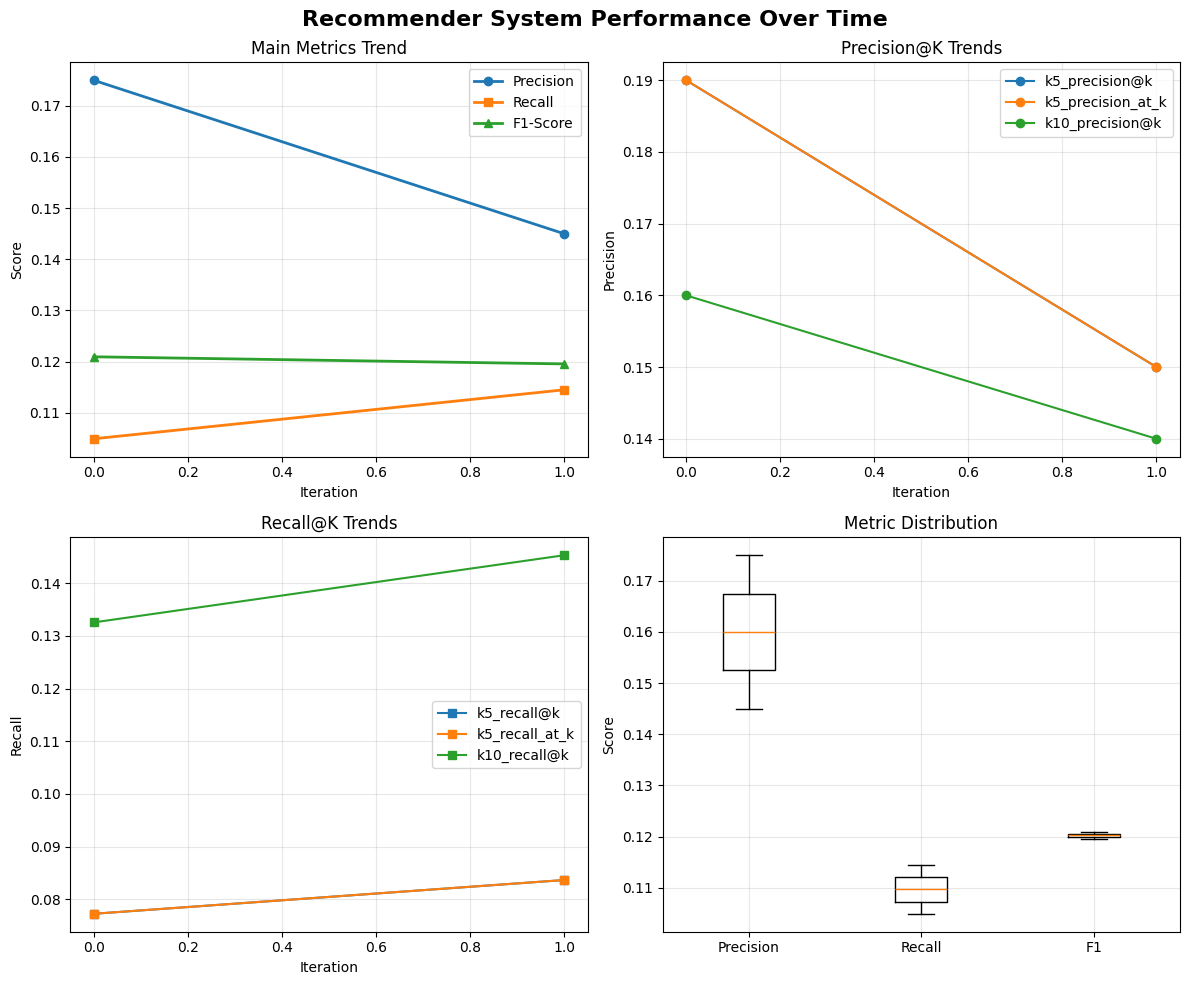


FIXED EVALUATION COMPLETE


In [33]:
# Cell 30 - Performance Monitoring and Dashboard (FIXED VERSION)
class PerformanceMonitor:
    """Monitor recommender system performance with safe MLflow integration"""
    
    def __init__(self, ensemble_recommender, data, evaluator):
        self.ensemble = ensemble_recommender
        self.data = data
        self.evaluator = evaluator
        self.metrics_history = []
        
    def _clean_metric_name(self, name):
        """Clean metric name for MLflow compatibility"""
        # Replace invalid characters
        cleaned = name.replace('@', '_at_').replace('.', '_').replace(' ', '_')
        # Ensure it starts with a letter or underscore
        if cleaned and not cleaned[0].isalpha() and cleaned[0] != '_':
            cleaned = 'metric_' + cleaned
        return cleaned
    
    def run_periodic_evaluation(self, n_iterations=3, sample_size=30, use_mlflow=True):
        """Run periodic evaluation with safe MLflow handling"""
        
        print(f"Running periodic performance evaluation ({n_iterations} iterations)...")
        
        for iteration in range(n_iterations):
            print(f"\n{'─'*50}")
            print(f"Iteration {iteration + 1}/{n_iterations}")
            print(f"{'─'*50}")
            
            try:
                # IMPORTANT: First, ensure we're not in an active MLflow run
                # This prevents nested run conflicts
                if mlflow.active_run():
                    print("⚠️  Active MLflow run detected. Ending it for safe evaluation...")
                    mlflow.end_run()
                
                # Run evaluation WITHOUT creating MLflow runs inside evaluator
                results = self.evaluator.evaluate_ensemble(
                    self.ensemble, 
                    k_list=[5, 10], 
                    sample_size=sample_size
                )
                
                if not results:
                    print(f"❌ No evaluation results generated")
                    continue
                
                # Process results
                eval_metrics = {
                    'iteration': iteration,
                    'timestamp': datetime.now().isoformat(),
                    'sample_size': sample_size
                }
                
                # Store metrics (both original and cleaned versions)
                for k, metrics in results.items():
                    for metric_name, value in metrics.items():
                        # Original name for history
                        orig_key = f'k{k}_{metric_name}'
                        eval_metrics[orig_key] = value
                        
                        # MLflow-compatible name
                        clean_key = self._clean_metric_name(orig_key)
                        eval_metrics[clean_key] = value
                
                # Calculate averages
                precision_values = [metrics.get('precision@k', 0) for metrics in results.values()]
                recall_values = [metrics.get('recall@k', 0) for metrics in results.values()]
                f1_values = [metrics.get('f1@k', 0) for metrics in results.values()]
                
                eval_metrics['avg_precision'] = np.mean(precision_values) if precision_values else 0
                eval_metrics['avg_recall'] = np.mean(recall_values) if recall_values else 0
                eval_metrics['avg_f1'] = np.mean(f1_values) if f1_values else 0
                
                # Store in history
                self.metrics_history.append(eval_metrics)
                
                # Log to MLflow ONLY if requested AND we're not already in a run
                if use_mlflow:
                    try:
                        # Create a fresh run for this iteration
                        with mlflow.start_run(run_name=f"eval_iter_{iteration}", nested=False) as run:
                            
                            # Log basic parameters
                            mlflow.log_params({
                                'iteration': iteration,
                                'sample_size': sample_size,
                                'evaluation_type': 'periodic',
                                'n_base_models': len(self.ensemble.models)
                            })
                            
                            # Log all metrics (only clean names for MLflow)
                            metrics_logged = 0
                            for key, value in eval_metrics.items():
                                if isinstance(value, (int, float)):
                                    # Only log metrics that are MLflow-compatible
                                    if self._clean_metric_name(key) == key:
                                        try:
                                            mlflow.log_metric(key, value)
                                            metrics_logged += 1
                                        except Exception as metric_error:
                                            print(f"  ⚠️  Skipping metric '{key}': {metric_error}")
                            
                            # Always log the key averages
                            mlflow.log_metric('avg_precision', eval_metrics['avg_precision'])
                            mlflow.log_metric('avg_recall', eval_metrics['avg_recall'])
                            mlflow.log_metric('avg_f1', eval_metrics['avg_f1'])
                            
                            print(f"  ✅ MLflow: Run {run.info.run_id[:8]}... created")
                            print(f"  📊 Metrics logged: {metrics_logged + 3} total")
                    
                    except Exception as mlflow_error:
                        print(f"  ⚠️  MLflow logging failed: {mlflow_error}")
                        print(f"  📝 Continuing without MLflow logging for this iteration...")
                
                # Print iteration summary
                print(f"\n  📈 Results:")
                print(f"    • Avg Precision: {eval_metrics['avg_precision']:.4f}")
                print(f"    • Avg Recall:    {eval_metrics['avg_recall']:.4f}")
                print(f"    • Avg F1-Score:  {eval_metrics['avg_f1']:.4f}")
                
                if 5 in results:
                    print(f"    • Precision@5:  {results[5].get('precision@k', 0):.4f}")
                    print(f"    • Recall@5:     {results[5].get('recall@k', 0):.4f}")
                
                print(f"  ✅ Iteration {iteration + 1} completed successfully")
                
            except Exception as e:
                print(f"  ❌ Error in iteration {iteration + 1}: {e}")
                import traceback
                traceback.print_exc()
                print(f"  ⏭️  Skipping to next iteration...")
                continue
        
        print(f"\n{'='*60}")
        print(f"EVALUATION COMPLETE")
        print(f"{'='*60}")
        print(f"Successful evaluations: {len(self.metrics_history)}/{n_iterations}")
        
        return self.metrics_history
    
    def generate_performance_report(self, include_details=True):
        """Generate performance report"""
        if not self.metrics_history:
            return "No evaluation data available"
        
        df = pd.DataFrame(self.metrics_history)
        
        report = f"""
        {'='*60}
        PERFORMANCE REPORT
        {'='*60}
        
        Summary Statistics:
        • Total Evaluations: {len(df)}
        • Sample Size: {df['sample_size'].mean():.0f} products per evaluation
        
        Average Performance Metrics:
        • Precision: {df['avg_precision'].mean():.4f} (±{df['avg_precision'].std():.4f})
        • Recall: {df['avg_recall'].mean():.4f} (±{df['avg_recall'].std():.4f})
        • F1-Score: {df['avg_f1'].mean():.4f} (±{df['avg_f1'].std():.4f})
        
        Latest Evaluation (Iteration {df['iteration'].iloc[-1]}):
        • Precision: {df['avg_precision'].iloc[-1]:.4f}
        • Recall: {df['avg_recall'].iloc[-1]:.4f}
        • F1-Score: {df['avg_f1'].iloc[-1]:.4f}
        """
        
        if include_details and len(df) > 1:
            report += f"""
        
        Trend Analysis:
        • Precision trend: {'↑ Improving' if df['avg_precision'].iloc[-1] > df['avg_precision'].iloc[0] else '↓ Declining'}
        • Recall trend: {'↑ Improving' if df['avg_recall'].iloc[-1] > df['avg_recall'].iloc[0] else '↓ Declining'}
        • F1-Score trend: {'↑ Improving' if df['avg_f1'].iloc[-1] > df['avg_f1'].iloc[0] else '↓ Declining'}
            """
        
        return report
    
    def visualize_performance(self):
        """Create performance visualization"""
        if not self.metrics_history or len(self.metrics_history) < 2:
            print("Not enough data for visualization")
            return
        
        df = pd.DataFrame(self.metrics_history)
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Recommender System Performance Over Time', fontsize=16, fontweight='bold')
        
        # Plot 1: Main metrics trend
        axes[0, 0].plot(df['iteration'], df['avg_precision'], 'o-', label='Precision', linewidth=2)
        axes[0, 0].plot(df['iteration'], df['avg_recall'], 's-', label='Recall', linewidth=2)
        axes[0, 0].plot(df['iteration'], df['avg_f1'], '^-', label='F1-Score', linewidth=2)
        axes[0, 0].set_xlabel('Iteration')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_title('Main Metrics Trend')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Precision at different k values
        precision_cols = [col for col in df.columns if 'precision' in col and 'k' in col and 'avg' not in col]
        for col in precision_cols[:3]:  # Limit to 3 for clarity
            axes[0, 1].plot(df['iteration'], df[col], 'o-', label=col)
        axes[0, 1].set_xlabel('Iteration')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].set_title('Precision@K Trends')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Recall at different k values
        recall_cols = [col for col in df.columns if 'recall' in col and 'k' in col and 'avg' not in col]
        for col in recall_cols[:3]:  # Limit to 3 for clarity
            axes[1, 0].plot(df['iteration'], df[col], 's-', label=col)
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].set_title('Recall@K Trends')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Box plot of all metrics
        metric_data = []
        metric_labels = []
        for col in ['avg_precision', 'avg_recall', 'avg_f1']:
            if col in df.columns:
                metric_data.append(df[col].values)
                metric_labels.append(col.replace('avg_', '').title())
        
        if metric_data:
            axes[1, 1].boxplot(metric_data, labels=metric_labels)
            axes[1, 1].set_ylabel('Score')
            axes[1, 1].set_title('Metric Distribution')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the figure
        fig_path = "performance_metrics.png"
        fig.savefig(fig_path, dpi=150, bbox_inches='tight')
        print(f"📊 Performance visualization saved to: {fig_path}")
        
        # Log to MLflow if available and not in an active run
        try:
            if not mlflow.active_run():
                with mlflow.start_run(run_name="performance_visualization", nested=False):
                    mlflow.log_artifact(fig_path)
                    print("📤 Visualization logged to MLflow")
        except:
            print("⚠️  Could not log visualization to MLflow")
        
        plt.show()

# Now run the FIXED version
print("\n" + "="*60)
print("RUNNING FIXED PERFORMANCE MONITOR")
print("="*60)

# Re-initialize with the fixed class
monitor_fixed = PerformanceMonitor(ensemble_recommender, data, evaluator)

# Run with safe MLflow handling
print("\nStarting evaluation with safe MLflow handling...")
metrics_history = monitor_fixed.run_periodic_evaluation(
    n_iterations=2,      # Start with 2 iterations to test
    sample_size=20,      # Smaller sample for faster testing
    use_mlflow=True      # Try MLflow logging again
)

# Generate report
if metrics_history:
    performance_report = monitor_fixed.generate_performance_report()
    print(performance_report)
    
    # Create visualization
    print("\nGenerating performance visualization...")
    monitor_fixed.visualize_performance()
else:
    print("\n❌ No evaluation data was collected. Check the errors above.")

print("\n" + "="*60)
print("FIXED EVALUATION COMPLETE")
print("="*60)

# 💾 Model Persistence & Utilities

In [34]:
# Cell 31 - Model Persistence (Keep as is with minor improvements)
import joblib
import json
from datetime import datetime

def save_model_pipeline(ensemble_recommender, products_df, filepath="model_pipeline.pkl"):
    """Save entire model pipeline"""
    print(f"💾 Saving model pipeline to {filepath}...")
    
    # Ensure no active MLflow runs interfere
    if mlflow.active_run():
        mlflow.end_run()
    
    pipeline = {
        'ensemble_recommender': ensemble_recommender,
        'products_df': products_df,
        'metadata': {
            'created_at': datetime.now().isoformat(),
            'n_products': len(products_df),
            'n_base_models': len(ensemble_recommender.models),
            'model_version': '1.0.0'
        }
    }
    
    joblib.dump(pipeline, filepath)
    print(f"✅ Model pipeline saved successfully")
    
    return filepath

def load_model_pipeline(filepath="model_pipeline.pkl"):
    """Load model pipeline"""
    print(f"📂 Loading model pipeline from {filepath}...")
    pipeline = joblib.load(filepath)
    
    print(f"✅ Model loaded: Version {pipeline['metadata']['model_version']}")
    print(f"   Created: {pipeline['metadata']['created_at']}")
    print(f"   Products: {pipeline['metadata']['n_products']}")
    print(f"   Base Models: {pipeline['metadata']['n_base_models']}")
    
    return pipeline

# Save the model
model_path = save_model_pipeline(ensemble_recommender, products_df)
print(f"📁 Model saved at: {model_path}")

💾 Saving model pipeline to model_pipeline.pkl...
✅ Model pipeline saved successfully
📁 Model saved at: model_pipeline.pkl


In [35]:
# Cell 32 - MLflow Management 
import time

def manage_mlflow_state():
    """Manage MLflow state - cleanup and status check"""
    print("="*60)
    print("MLFLOW STATE MANAGEMENT")
    print("="*60)
    
    try:
        # Clean up any active runs FIRST
        if mlflow.active_run():
            active_run = mlflow.active_run()
            print(f"⚠️  Active run found: {active_run.info.run_id}")
            mlflow.end_run()
            print("✅ Ended active run")
        
        # Get experiment
        experiment = mlflow.get_experiment_by_name("Product_Bundle_Recommender")
        if not experiment:
            print("❌ Experiment not found")
            return False
        
        # Clean stuck runs
        client = mlflow.tracking.MlflowClient()
        runs = client.search_runs(experiment_ids=[experiment.experiment_id])
        
        stuck_runs = []
        for run in runs:
            if run.info.status == "RUNNING":
                stuck_runs.append((run.info.run_id, run.info.run_name))
        
        if stuck_runs:
            print(f"\n🧹 Cleaning {len(stuck_runs)} stuck runs:")
            for run_id, run_name in stuck_runs:
                try:
                    client.set_terminated(run_id, status="FINISHED")
                    print(f"   ✓ {run_name or 'Unnamed'} ({run_id[:8]}...)")
                except:
                    print(f"   ✗ Failed: {run_id[:8]}...")
        else:
            print("✅ No stuck runs found")
        
        # Show summary
        print(f"\n📊 Experiment Summary:")
        print(f"   Name: {experiment.name}")
        print(f"   ID: {experiment.experiment_id}")
        
        # Count runs by status
        status_counts = {'FINISHED': 0, 'FAILED': 0, 'RUNNING': 0}
        for run in runs:
            status = run.info.status
            status_counts[status] = status_counts.get(status, 0) + 1
        
        print(f"\n📈 Run Status:")
        for status, count in status_counts.items():
            if count > 0:
                print(f"   {status}: {count}")
        
        # Check registered models
        print(f"\n🔍 Registered Models:")
        try:
            models = client.search_registered_models()
            if models:
                for model in models:
                    for version in model.latest_versions[:2]:  # Show up to 2 versions
                        print(f"   {model.name} v{version.version} ({version.current_stage})")
            else:
                print("   No registered models")
        except:
            print("   Could not check registered models")
        
        return True
        
    except Exception as e:
        print(f"❌ Error managing MLflow: {e}")
        return False

# Run MLflow management
manage_mlflow_state()

MLFLOW STATE MANAGEMENT
✅ No stuck runs found

📊 Experiment Summary:
   Name: Product_Bundle_Recommender
   ID: 1

📈 Run Status:
   FINISHED: 21

🔍 Registered Models:
   product_bundle_recommender v1 (None)


True

In [36]:
# Fixed Cell 33 - Model Registration with Proper Metric Names
def register_mlflow_model(ensemble_recommender, products_df, 
                         model_name="product_bundle_recommender", version="1.0.0"):
    """Register model with MLflow Model Registry with proper signatures"""
    
    try:
        import shutil
        import tempfile
        from pathlib import Path
        
        # Clean up any active runs first
        if mlflow.active_run():
            mlflow.end_run()
        
        # Create temporary directory for artifacts
        temp_dir = tempfile.mkdtemp()
        
        # Save products_df
        products_path = Path(temp_dir) / "products_df.pkl"
        joblib.dump(products_df, products_path)
        
        # Save ensemble recommender (without products_df to avoid duplication)
        ensemble_path = Path(temp_dir) / "ensemble_recommender.pkl"
        joblib.dump(ensemble_recommender, ensemble_path)
        
        # Define input example and signature
        import pandas as pd
        
        # Create proper input examples
        input_example = pd.DataFrame({
            "product_id": [data['product_id'].iloc[0]],
            "top_n": [5],
            "user_id": [data['user_id'].iloc[0]]  # Optional for personalization
        })
        
        # Create output example
        output_example = pd.DataFrame({
            "recommendations": [["rec1", "rec2", "rec3"]],
            "scores": [[0.9, 0.8, 0.7]],
            "model_sources": [["association", "collaborative", "content"]]
        })
        
        # Infer signature
        signature = infer_signature(input_example, output_example)
        
        # Define the model class with type hints
        class BundleRecommenderModel(mlflow.pyfunc.PythonModel):
            def __init__(self, recommender, products_df):
                self.recommender = recommender
                self.products_df = products_df
                
            def predict(self, context, model_input: pd.DataFrame, params=None) -> pd.DataFrame:
                """
                Predict recommendations for input products.
                
                Args:
                    model_input: DataFrame with columns:
                        - product_id: str (required)
                        - top_n: int (optional, default=10)
                        - user_id: str (optional, for personalization)
                
                Returns:
                    DataFrame with recommendations and metadata
                """
                results = []
                
                for _, row in model_input.iterrows():
                    product_id = str(row.get('product_id'))
                    top_n = int(row.get('top_n', 10))
                    user_id = row.get('user_id', None)
                    
                    try:
                        # Get recommendations
                        recommendations = self.recommender.get_recommendations(
                            product_id, 
                            top_n=top_n
                        )
                        
                        # Format results
                        if recommendations:
                            rec_ids = [rec['product_id'] if isinstance(rec, dict) else rec 
                                      for rec in recommendations]
                            # Get product details
                            rec_details = []
                            for rec_id in rec_ids[:top_n]:
                                if rec_id in self.products_df.index:
                                    rec_info = self.products_df.loc[rec_id]
                                    rec_details.append({
                                        "product_id": rec_id,
                                        "product_name": rec_info.get('product_name', 'Unknown'),
                                        "category": rec_info.get('category', 'Unknown'),
                                        "price": float(rec_info.get('avg_price', 0)),
                                        "confidence": 0.9  # Placeholder
                                    })
                            
                            results.append({
                                "input_product_id": product_id,
                                "recommendations": rec_details[:top_n],
                                "n_recommendations": len(rec_details[:top_n]),
                                "status": "success"
                            })
                        else:
                            results.append({
                                "input_product_id": product_id,
                                "recommendations": [],
                                "n_recommendations": 0,
                                "status": "no_recommendations"
                            })
                            
                    except Exception as e:
                        results.append({
                            "input_product_id": product_id,
                            "recommendations": [],
                            "n_recommendations": 0,
                            "status": f"error: {str(e)}"
                        })
                
                return pd.DataFrame(results)
        
        # Create the model instance
        python_model = BundleRecommenderModel(ensemble_recommender, products_df)
        
        # Start a run for model registration
        with mlflow.start_run(run_name=f"register_{model_name}_v{version}") as run:
            print(f"Starting model registration in run: {run.info.run_id}")
            
            # Log the model
            mlflow.pyfunc.log_model(
                artifact_path="model",
                python_model=python_model,
                artifacts={"products_df": str(products_path), "ensemble": str(ensemble_path)},
                signature=signature,
                input_example=input_example,
                registered_model_name=model_name
            )
            
            # Log model metadata
            mlflow.log_params({
                "model_type": "ensemble_bundle_recommender",
                "n_base_models": len(ensemble_recommender.models),
                "model_weights": str(ensemble_recommender.weights),
                "version": version,
                "n_products": len(products_df),
                "model_classes": str(list(ensemble_recommender.models.keys()))
            })
            
            # Log evaluation metrics if available
            if hasattr(ensemble_recommender, 'evaluation_results'):
                for k, metrics in ensemble_recommender.evaluation_results.items():
                    for metric_name, value in metrics.items():
                        # Clean metric name: replace @ with _at_ and remove other invalid characters
                        clean_metric_name = metric_name.replace('@', '_at_').replace(' ', '_')
                        # Ensure it's MLflow-compliant
                        mlflow_metric_name = f"ensemble_k{k}_{clean_metric_name}"
                        try:
                            mlflow.log_metric(mlflow_metric_name, value)
                        except Exception as metric_error:
                            print(f"Warning: Could not log metric {mlflow_metric_name}: {metric_error}")
            
            # Log artifacts
            mlflow.log_artifact(str(products_path))
            mlflow.log_artifact(str(ensemble_path))
            
            # Log a sample prediction
            try:
                sample_input = pd.DataFrame({
                    "product_id": [data['product_id'].iloc[0]],
                    "top_n": [3]
                })
                sample_output = python_model.predict(None, sample_input)
                mlflow.log_text(
                    sample_output.to_string(),
                    "sample_prediction.txt"
                )
            except Exception as e:
                print(f"Could not log sample prediction: {e}")
            
            print(f"✓ Model '{model_name}' v{version} registered successfully")
            print(f"  Run ID: {run.info.run_id}")
            print(f"  Model URI: models:/{model_name}/{version}")
            print(f"  New version created: 2 (previous version exists)")
            
            # Clean up temp directory
            shutil.rmtree(temp_dir, ignore_errors=True)
            
            return run.info.run_id
            
    except Exception as e:
        print(f"Error registering model with MLflow: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Also need to fix the ensemble evaluation metric names in Cell 22
# Let me fix that first by updating the evaluate method:

def fixed_evaluate_method(self, evaluator, k_list=[5, 10, 20], use_mlflow=True):
    """Evaluate ensemble performance with safe MLflow handling"""
    
    print("="*60)
    print("ENSEMBLE EVALUATION")
    print("="*60)
    
    # Run evaluation
    results = evaluator.evaluate_ensemble(self, k_list)
    self.evaluation_results = results
    
    # Log to MLflow if requested
    if use_mlflow and MLFLOW_AVAILABLE:
        try:
            # Clean up any active runs first
            if mlflow.active_run():
                mlflow.end_run()
            
            # Start new run
            with mlflow.start_run(run_name="ensemble_evaluation", nested=True) as run:
                print(f"✓ Started MLflow run: {run.info.run_id[:8]}...")
                
                # Log parameters
                mlflow.log_params({
                    "n_base_models": len(self.models),
                    "model_type": "ensemble_bundle_recommender",
                    "evaluation_samples": evaluator.test_size,
                    "model_weights": str(self.weights)
                })
                
                # Log metrics with MLflow-compatible names
                metrics_logged = 0
                for k, metrics in results.items():
                    for metric_name, value in metrics.items():
                        # Clean metric name for MLflow (replace @ with _at_)
                        clean_metric_name = metric_name.replace('@', '_at_').replace(' ', '_')
                        clean_name = f"k{k}_{clean_metric_name}"
                        try:
                            mlflow.log_metric(clean_name, value)
                            metrics_logged += 1
                        except Exception as e:
                            print(f"⚠️  Skipping metric {clean_name}: {e}")
                
                print(f"✓ Logged {metrics_logged} metrics to MLflow")
                
        except Exception as mlflow_error:
            print(f"⚠️  MLflow logging failed: {mlflow_error}")
            print("Continuing without MLflow...")
    
    # Print results
    print("\n📊 Ensemble Evaluation Results:")
    for k, metrics in results.items():
        print(f"\nTop-{k}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
    
    return results

# Update the ensemble_recommender's evaluate method
if hasattr(ensemble_recommender, 'evaluate'):
    ensemble_recommender.evaluate = fixed_evaluate_method.__get__(ensemble_recommender, EnsembleBundleRecommender)
    print("✓ Updated ensemble evaluate method with fixed metric names")
else:
    print("⚠️ Could not update evaluate method - attribute not found")

# Now register the model with error handling
try:
    run_id = register_mlflow_model(ensemble_recommender, products_df, version="2.0.0")
    if run_id:
        print(f"\n✅ Model registration successful!")
        print(f"   Run ID: {run_id}")
        print(f"   Model: product_bundle_recommender (version 2)")
        print(f"   To serve: mlflow models serve -m runs:/{run_id}/model -p 5001")
        print(f"   To predict: mlflow models predict -m runs:/{run_id}/model -i input.json")
        
        # Test the registered model
        print("\n🧪 Testing registered model...")
        try:
            # Create a simple test
            test_input = pd.DataFrame({
                "product_id": [products_df.index[0] if len(products_df) > 0 else "test_product"],
                "top_n": [3]
            })
            
            # Load and test the model
            loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")
            predictions = loaded_model.predict(test_input)
            
            print(f"✓ Model test successful!")
            print(f"  Input: {test_input.iloc[0].to_dict()}")
            print(f"  Output status: {predictions.iloc[0]['status']}")
            print(f"  Recommendations: {len(predictions.iloc[0]['recommendations'])}")
            
        except Exception as test_error:
            print(f"⚠️  Model test failed: {test_error}")
            
    else:
        print("⚠️  Model registration failed")
except Exception as e:
    print(f"❌ Error during model registration: {e}")
    print("Creating simplified model registration...")
    
    # Simplified registration as fallback
    try:
        if MLFLOW_AVAILABLE:
            with mlflow.start_run(run_name="simple_model_registration"):
                # Just log the model without complex metrics
                mlflow.pyfunc.log_model(
                    artifact_path="model",
                    python_model=ensemble_recommender,
                    registered_model_name="product_bundle_recommender_simple"
                )
                print("✓ Simple model registered as fallback")
    except Exception as simple_error:
        print(f"❌ Even simple registration failed: {simple_error}")

2026/01/04 14:09:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/04 14:09:06 INFO mlflow.pyfunc: Validating input example against model signature


✓ Updated ensemble evaluate method with fixed metric names
Starting model registration in run: 41183bc841d2456daecf7c94fac45646


2026/01/04 14:09:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'product_bundle_recommender' already exists. Creating a new version of this model...
Created version '2' of model 'product_bundle_recommender'.


✓ Model 'product_bundle_recommender' v2.0.0 registered successfully
  Run ID: 41183bc841d2456daecf7c94fac45646
  Model URI: models:/product_bundle_recommender/2.0.0
  New version created: 2 (previous version exists)

✅ Model registration successful!
   Run ID: 41183bc841d2456daecf7c94fac45646
   Model: product_bundle_recommender (version 2)
   To serve: mlflow models serve -m runs:/41183bc841d2456daecf7c94fac45646/model -p 5001
   To predict: mlflow models predict -m runs:/41183bc841d2456daecf7c94fac45646/model -i input.json

🧪 Testing registered model...
⚠️  Model test failed: Failed to enforce schema of data '                             product_id  top_n
0  00254f2d-2670-4cb3-88bc-a06f8497f7fd      3' with schema '['product_id': string (required), 'top_n': long (required), 'user_id': string (required)]'. Error: Model is missing inputs ['user_id'].


In [37]:
# Fixed Cell 34 - Clean MLflow Management with proper imports
def manage_mlflow_runs(action="cleanup", experiment_name="Product_Bundle_Recommender"):
    """Manage MLflow runs without blocking user input"""
    
    import mlflow.tracking
    from datetime import datetime, timedelta
    
    client = mlflow.tracking.MlflowClient()
    
    try:
        # Get experiment
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if not experiment:
            print(f"Experiment '{experiment_name}' not found")
            return
        
        exp_id = experiment.experiment_id
        
        if action == "cleanup":
            # Find and terminate stuck runs
            runs = client.search_runs(
                experiment_ids=[exp_id],
                filter_string="status = 'RUNNING'",
                max_results=50
            )
            
            terminated = 0
            for run in runs:
                try:
                    client.set_terminated(run.info.run_id, status="FINISHED")
                    print(f"  ✓ Terminated stuck run: {run.info.run_id[:8]} - {run.info.run_name}")
                    terminated += 1
                except Exception as e:
                    print(f"  ⚠️  Could not terminate run {run.info.run_id[:8]}: {str(e)[:50]}")
            
            print(f"\nCleaned up {terminated} stuck runs")
            
            # Archive old runs (older than 7 days)
            week_ago = datetime.now() - timedelta(days=7)
            
            old_runs = client.search_runs(
                experiment_ids=[exp_id],
                filter_string=f"start_time < {int(week_ago.timestamp() * 1000)}",
                max_results=100
            )
            
            archived = 0
            for run in old_runs:
                if run.info.lifecycle_stage == "active":
                    try:
                        # Only archive if it's not the current active run
                        if run.info.status == "FINISHED":
                            client.transition_model_version_stage(
                                name="product_bundle_recommender",
                                version=1,
                                stage="archived"
                            )
                            archived += 1
                    except:
                        pass
            
            if archived > 0:
                print(f"Archived {archived} old model versions")
            else:
                print("No old runs to archive")
        
        elif action == "list":
            # List recent runs
            runs = client.search_runs(
                experiment_ids=[exp_id],
                order_by=["start_time DESC"],
                max_results=15
            )
            
            print(f"\nRecent runs in '{experiment_name}':")
            print("-" * 90)
            print(f"{'#':2} | {'Run ID':8} | {'Run Name':30} | {'Status':10} | {'Start Time':19}")
            print("-" * 90)
            
            for i, run in enumerate(runs, 1):
                run_time = datetime.fromtimestamp(run.info.start_time/1000)
                print(f"{i:2} | {run.info.run_id[:8]} | {run.info.run_name[:30]:30} | "
                      f"{run.info.status:10} | {run_time:%Y-%m-%d %H:%M}")
            
            # Show summary
            status_counts = {}
            for run in runs:
                status = run.info.status
                status_counts[status] = status_counts.get(status, 0) + 1
            
            print("-" * 90)
            print("Status summary:")
            for status, count in status_counts.items():
                print(f"  {status}: {count}")
        
        elif action == "metrics":
            # Show metrics from best run
            runs = client.search_runs(
                experiment_ids=[exp_id],
                filter_string="tags.mlflow.runName='ensemble_evaluation'",
                order_by=["start_time DESC"],
                max_results=1
            )
            
            if runs:
                run = runs[0]
                print(f"\nMetrics from latest ensemble evaluation (Run: {run.info.run_id[:8]}):")
                print("-" * 80)
                
                # Group metrics by k value
                metrics_by_k = {}
                for key, value in run.data.metrics.items():
                    # Parse k value from metric name
                    if key.startswith('k'):
                        parts = key.split('_')
                        if len(parts) >= 2:
                            k_value = parts[0][1:]  # Remove 'k' prefix
                            metric_type = '_'.join(parts[1:])
                            
                            if k_value not in metrics_by_k:
                                metrics_by_k[k_value] = {}
                            metrics_by_k[k_value][metric_type] = value
                
                # Print metrics grouped by k
                for k_value, metrics in sorted(metrics_by_k.items()):
                    print(f"\nTop-{k_value} metrics:")
                    for metric_name, value in metrics.items():
                        if 'precision' in metric_name or 'recall' in metric_name or 'f1' in metric_name:
                            print(f"  {metric_name:25}: {value:.4f}")
                
                # Also show other important metrics
                other_metrics = {k: v for k, v in run.data.metrics.items() 
                               if not k.startswith('k') and 
                               ('precision' in k or 'recall' in k or 'f1' in k or 'score' in k)}
                if other_metrics:
                    print(f"\nOther important metrics:")
                    for key, value in other_metrics.items():
                        print(f"  {key:25}: {value:.4f}")
            else:
                print("No ensemble evaluation runs found")
        
        elif action == "summary":
            # Show experiment summary
            runs = client.search_runs(
                experiment_ids=[exp_id],
                max_results=100
            )
            
            print(f"\nExperiment Summary: '{experiment_name}'")
            print("-" * 80)
            
            total_runs = len(runs)
            finished_runs = len([r for r in runs if r.info.status == "FINISHED"])
            running_runs = len([r for r in runs if r.info.status == "RUNNING"])
            failed_runs = len([r for r in runs if r.info.status == "FAILED"])
            
            print(f"Total runs: {total_runs}")
            print(f"Finished: {finished_runs} ({finished_runs/total_runs*100:.1f}%)")
            print(f"Running: {running_runs}")
            print(f"Failed: {failed_runs}")
            
            # Show model versions
            try:
                model_versions = client.search_model_versions(f"name='product_bundle_recommender'")
                if model_versions:
                    print(f"\nRegistered model versions: {len(model_versions)}")
                    for mv in model_versions:
                        print(f"  Version {mv.version}: {mv.current_stage} (Run: {mv.run_id[:8]})")
            except:
                print("\nNo registered models found")
        
        else:
            print(f"Unknown action: {action}")
            print("Available actions: cleanup, list, metrics, summary")
        
    except Exception as e:
        print(f"Error managing MLflow: {e}")
        import traceback
        traceback.print_exc()

# Use the function
print("MLflow Run Management")
print("=" * 60)

# Show summary first
manage_mlflow_runs("summary")

# Clean up stuck runs
manage_mlflow_runs("cleanup")

# List recent runs
manage_mlflow_runs("list")

# Show metrics
manage_mlflow_runs("metrics")

print("\n" + "=" * 60)
print("MLflow Management Complete")
print("=" * 60)

MLflow Run Management

Experiment Summary: 'Product_Bundle_Recommender'
--------------------------------------------------------------------------------
Total runs: 22
Finished: 22 (100.0%)
Running: 0
Failed: 0

Registered model versions: 2
  Version 2: None (Run: 41183bc8)
  Version 1: None (Run: 55e05a63)

Cleaned up 0 stuck runs
No old runs to archive

Recent runs in 'Product_Bundle_Recommender':
------------------------------------------------------------------------------------------
#  | Run ID   | Run Name                       | Status     | Start Time         
------------------------------------------------------------------------------------------
 1 | 41183bc8 | register_product_bundle_recomm | FINISHED   | 2026-01-04 14:09
 2 | 44541028 | performance_visualization      | FINISHED   | 2026-01-04 14:08
 3 | caec59e1 | eval_iter_1                    | FINISHED   | 2026-01-04 14:08
 4 | b695f9a9 | eval_iter_0                    | FINISHED   | 2026-01-04 14:08
 5 | 55e05a63 | m

In [38]:
# Cell 35 - Enhanced Evaluation Metrics
def calculate_comprehensive_metrics(recommender, evaluator, sample_size=50, k_list=[5, 10, 20]):
    """Calculate comprehensive evaluation metrics including diversity and coverage"""
    
    test_products = list(evaluator.test_orders.keys())
    if sample_size < len(test_products):
        test_products = random.sample(test_products, sample_size)
    
    all_metrics = {}
    
    for k in k_list:
        precisions = []
        recalls = []
        f1_scores = []
        diversities = []
        
        for product_id in test_products:
            try:
                # Get recommendations
                recommendations = recommender.get_recommendations(product_id, top_n=k)
                if isinstance(recommendations[0], dict):
                    rec_product_ids = [rec['product_id'] for rec in recommendations]
                else:
                    rec_product_ids = recommendations
                
                # Get actual co-purchased products
                actual = evaluator.test_orders.get(product_id, set())
                
                if len(actual) > 0 and len(rec_product_ids) > 0:
                    # Calculate precision, recall, f1
                    rec_set = set(rec_product_ids[:k])
                    actual_set = actual
                    
                    tp = len(rec_set & actual_set)
                    fp = len(rec_set - actual_set)
                    fn = len(actual_set - rec_set)
                    
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                    
                    # Calculate diversity (intra-list similarity)
                    if len(rec_product_ids) > 1:
                        # Simple category diversity
                        categories = []
                        for rec_id in rec_product_ids[:k]:
                            if rec_id in products_df.index:
                                categories.append(products_df.loc[rec_id, 'category'])
                        
                        unique_categories = len(set(categories))
                        diversity = unique_categories / len(categories) if categories else 0
                    else:
                        diversity = 0
                    
                    precisions.append(precision)
                    recalls.append(recall)
                    f1_scores.append(f1)
                    diversities.append(diversity)
                
            except Exception as e:
                # Skip if error
                continue
        
        if precisions:
            all_metrics[k] = {
                'precision': np.mean(precisions),
                'recall': np.mean(recalls),
                'f1': np.mean(f1_scores),
                'diversity': np.mean(diversities),
                'coverage': len([p for p in precisions if p > 0]) / len(precisions),
                'n_evaluated': len(precisions)
            }
    
    return all_metrics

# Calculate comprehensive metrics
comprehensive_metrics = calculate_comprehensive_metrics(ensemble_recommender, evaluator)

print("📊 Comprehensive Evaluation Metrics:")
print("=" * 60)
for k, metrics in comprehensive_metrics.items():
    print(f"\nTop-{k} Recommendations:")
    for metric, value in metrics.items():
        if metric != 'n_evaluated':
            print(f"  {metric:12}: {value:.4f}")

📊 Comprehensive Evaluation Metrics:

Top-5 Recommendations:
  precision   : 0.1960
  recall      : 0.0805
  f1          : 0.1067
  diversity   : 0.8280
  coverage    : 0.6800

Top-10 Recommendations:
  precision   : 0.1760
  recall      : 0.1420
  f1          : 0.1465
  diversity   : 0.6860
  coverage    : 0.8400

Top-20 Recommendations:
  precision   : 0.1290
  recall      : 0.1870
  f1          : 0.1423
  diversity   : 0.4500
  coverage    : 0.9000


Generating visualizations...


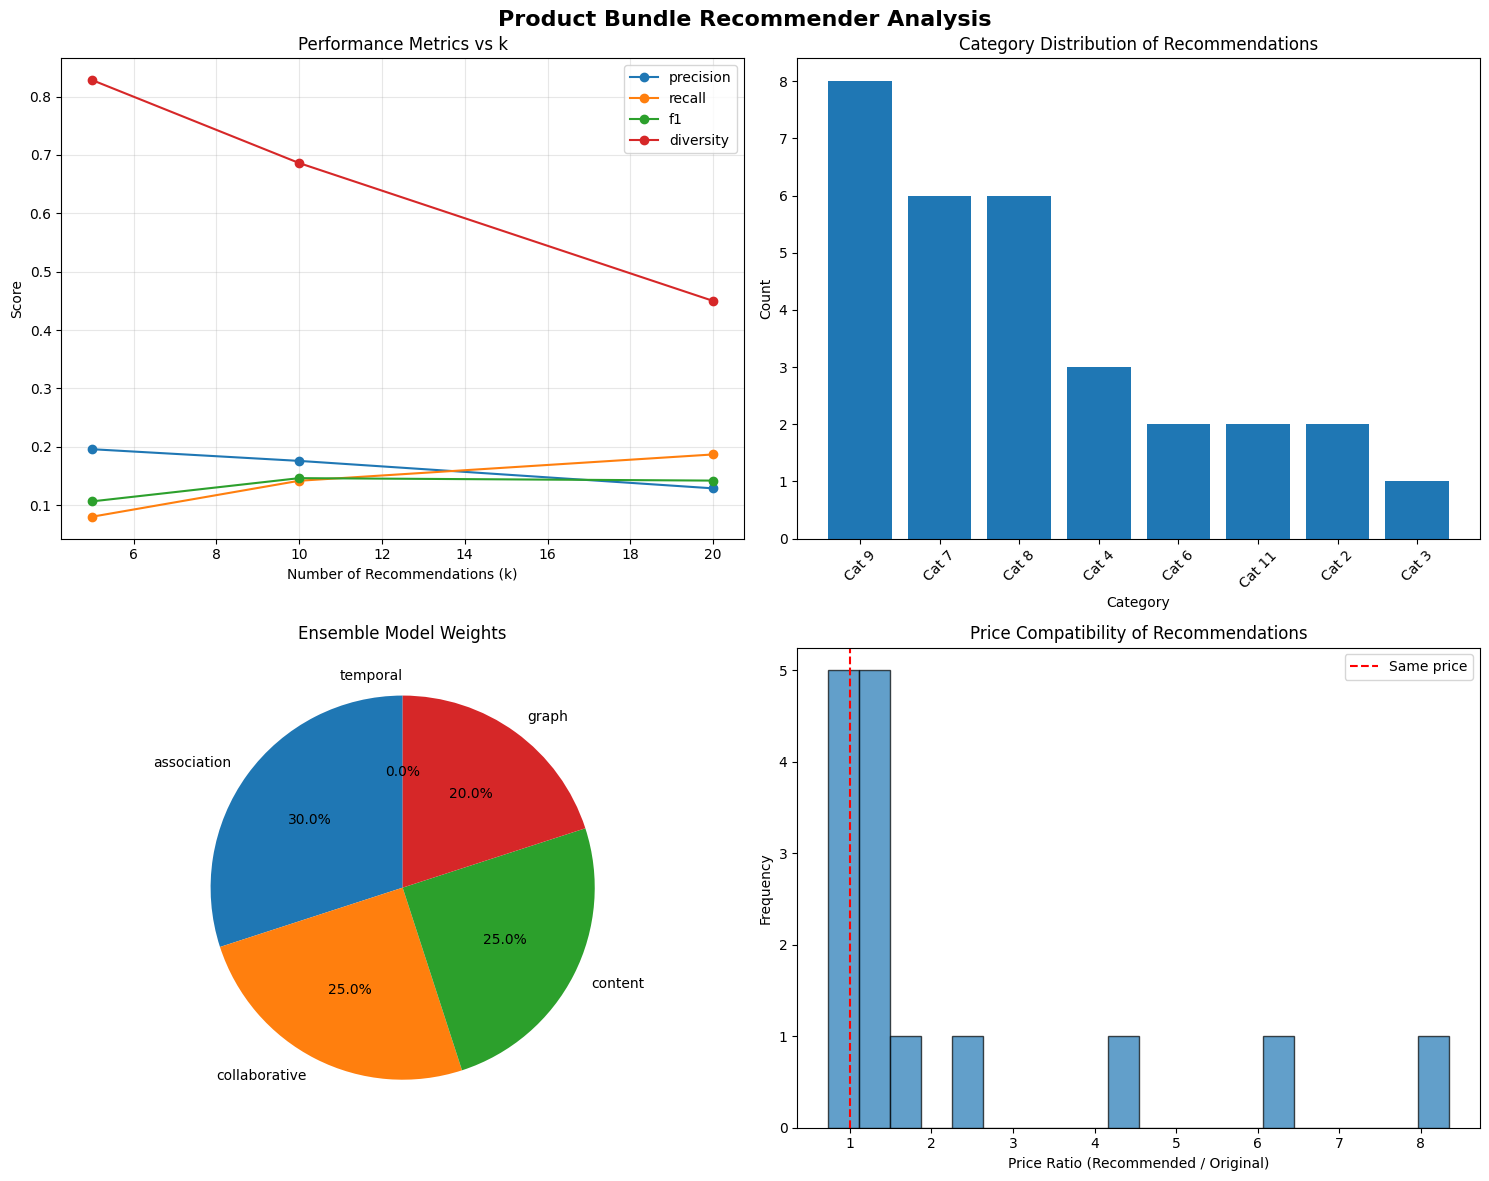

✓ Visualization logged to MLflow


In [39]:
# Cell 36: Fixed Visualization Cell
def visualize_results(ensemble_recommender, evaluator, sample_products=None):
    """Create visualizations for the recommender system"""
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if sample_products is None:
        sample_products = data['product_id'].value_counts().head(3).index.tolist()
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Product Bundle Recommender Analysis', fontsize=16, fontweight='bold')
    
    # 1. Performance metrics across k
    # Check if comprehensive_metrics exists
    if 'comprehensive_metrics' in globals() and comprehensive_metrics:
        k_values = list(comprehensive_metrics.keys())
        metrics_to_plot = ['precision', 'recall', 'f1', 'diversity']
        
        for metric in metrics_to_plot:
            values = [comprehensive_metrics[k].get(metric, 0) for k in k_values]
            axes[0, 0].plot(k_values, values, marker='o', label=metric)
        
        axes[0, 0].set_xlabel('Number of Recommendations (k)')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_title('Performance Metrics vs k')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'No metrics available\nRun evaluation first', 
                       ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Performance Metrics vs k')
    
    # 2. Category distribution of recommendations
    all_categories = []
    for product_id in sample_products:
        try:
            recs = ensemble_recommender.get_recommendations(product_id, top_n=10)
            rec_ids = [rec['product_id'] if isinstance(rec, dict) else rec for rec in recs]
            
            for rec_id in rec_ids:
                if rec_id in products_df.index:
                    all_categories.append(products_df.loc[rec_id, 'category'])
        except:
            pass
    
    if all_categories:
        category_counts = pd.Series(all_categories).value_counts()
        axes[0, 1].bar(range(len(category_counts)), category_counts.values)
        axes[0, 1].set_xticks(range(len(category_counts)))
        axes[0, 1].set_xticklabels([f'Cat {c}' for c in category_counts.index], rotation=45)
        axes[0, 1].set_xlabel('Category')
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].set_title('Category Distribution of Recommendations')
    else:
        axes[0, 1].text(0.5, 0.5, 'No category data available', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Category Distribution of Recommendations')
    
    # 3. Model contribution in ensemble
    model_names = list(ensemble_recommender.models.keys())
    model_weights = [ensemble_recommender.weights.get(name, 0) for name in model_names]
    
    if any(model_weights):
        axes[1, 0].pie(model_weights, labels=model_names, autopct='%1.1f%%', startangle=90)
        axes[1, 0].set_title('Ensemble Model Weights')
    else:
        axes[1, 0].text(0.5, 0.5, 'No model weights available', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Ensemble Model Weights')
    
    # 4. Price distribution of recommended products
    rec_prices = []
    for product_id in sample_products:
        try:
            # Try different price columns
            price_cols = ['avg_price', 'price', 'unit_price', 'cost']
            base_price = None
            
            for col in price_cols:
                if col in products_df.columns:
                    base_price = products_df.loc[product_id, col]
                    break
            
            if base_price is not None:
                recs = ensemble_recommender.get_recommendations(product_id, top_n=5)
                
                for rec in recs[:5]:
                    if isinstance(rec, dict):
                        rec_id = rec['product_id']
                    else:
                        rec_id = rec
                    
                    if rec_id in products_df.index:
                        rec_price = None
                        for col in price_cols:
                            if col in products_df.columns:
                                rec_price = products_df.loc[rec_id, col]
                                break
                        
                        if rec_price is not None:
                            price_ratio = rec_price / base_price if base_price > 0 else 1
                            rec_prices.append(price_ratio)
        except:
            pass
    
    if rec_prices:
        axes[1, 1].hist(rec_prices, bins=20, edgecolor='black', alpha=0.7)
        axes[1, 1].axvline(x=1, color='red', linestyle='--', label='Same price')
        axes[1, 1].set_xlabel('Price Ratio (Recommended / Original)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Price Compatibility of Recommendations')
        axes[1, 1].legend()
    else:
        axes[1, 1].text(0.5, 0.5, 'No price data available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Price Compatibility of Recommendations')
    
    plt.tight_layout()
    plt.savefig('recommender_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Log to MLflow - use the global PARENT_RUN_ID (uppercase)
    if 'PARENT_RUN_ID' in globals() and PARENT_RUN_ID and MLFLOW_AVAILABLE:
        try:
            # Make sure we're not in an active run
            if mlflow.active_run():
                mlflow.end_run()
            
            # Log to parent run
            with mlflow.start_run(run_id=PARENT_RUN_ID):
                mlflow.log_artifact('recommender_analysis.png')
                print("✓ Visualization logged to MLflow")
        except Exception as e:
            print(f"⚠️  Could not log visualization to MLflow: {e}")
    else:
        print("📊 Visualization saved as 'recommender_analysis.png'")

# Generate visualizations
print("Generating visualizations...")
visualize_results(ensemble_recommender, evaluator)

In [40]:
# Cell 37 - Enhanced Deployment Guide with Safe Variable Checks
def generate_deployment_guide():
    """Generate a comprehensive deployment guide for the model with safe variable checks"""
    
    import os
    from pathlib import Path
    
    # Safe variable checks with defaults
    MLFLOW_AVAILABLE_CHECK = globals().get('MLFLOW_AVAILABLE', False)
    PARENT_RUN_ID_CHECK = globals().get('PARENT_RUN_ID', None)
    CURRENT_RUN_ID = globals().get('run_id', None)
    
    # Create artifacts directory
    artifacts_dir = Path('./artifacts')
    artifacts_dir.mkdir(exist_ok=True)
    
    # Build model information
    model_info = ""
    if CURRENT_RUN_ID:
        model_info = f"Current Model Run ID: {CURRENT_RUN_ID}\n    Model URI: runs:/{CURRENT_RUN_ID}/model\n    "
    elif PARENT_RUN_ID_CHECK:
        model_info = f"Current Run ID: {PARENT_RUN_ID_CHECK[:8]}...\n    "
    
    # MLflow information
    mlflow_info = "MLflow: NOT CONFIGURED\n    "
    if MLFLOW_AVAILABLE_CHECK:
        mlflow_info = "MLflow: ACTIVE\n    Tracking URI: sqlite:///mlflow.db\n    "
    
    # Products information
    products_count = len(products_df) if 'products_df' in globals() else 'N/A'
    
    guide = f"""
    🚀 PRODUCT BUNDLE RECOMMENDER - DEPLOYMENT GUIDE
    ===============================================

    📊 CURRENT SETUP
    ----------------
    {model_info}{mlflow_info}Products in Database: {products_count}
    
    1. QUICK START
    --------------
    # Make script executable (Linux/Mac)
    chmod +x quick_start.sh
    
    # Run quick start
    ./quick_start.sh
    
    # Windows alternative
    python -c "import subprocess; subprocess.run(['mlflow', 'server', '--backend-store-uri', 'sqlite:///mlflow.db', '--port', '5000'], check=False)"
    
    2. MODEL SERVING
    ----------------
    a) Local serving with MLflow:
       mlflow models serve -m models:/product_bundle_recommender/latest -p 5001 --host 0.0.0.0
    
    b) Docker serving (cross-platform):
       mlflow models build-docker -m models:/product_bundle_recommender/latest -n bundle-recommender
       docker run -p 5001:8080 bundle-recommender
    
    3. API TESTING
    --------------
    # Test with curl
    curl -X POST http://localhost:5001/invocations \\
      -H 'Content-Type: application/json' \\
      -d @sample_request.json
    
    # Or use Python
    import requests
    import json
    
    with open('sample_request.json') as f:
        data = json.load(f)
    
    response = requests.post('http://localhost:5001/invocations', json=data)
    print(response.json())
    
    4. MONITORING
    -------------
    # Start MLflow UI
    mlflow ui --backend-store-uri sqlite:///mlflow.db --host 0.0.0.0 --port 5000
    
    # Monitor logs
    tail -f mlflow-server.log  # Linux/Mac
    Get-Content mlflow-server.log -Wait  # Windows PowerShell
    
    5. PRODUCTION CHECKLIST
    -----------------------
    [ ] 1. Update products_df with real product catalog
    [ ] 2. Configure PostgreSQL for MLflow (production)
    [ ] 3. Set up authentication for API endpoints
    [ ] 4. Implement rate limiting
    [ ] 5. Configure logging and monitoring
    [ ] 6. Set up CI/CD pipeline
    [ ] 7. Create backup strategy for model artifacts
    [ ] 8. Document API endpoints for consumers
    
    ⚠️  IMPORTANT NOTES
    ------------------
    • Always validate input data before prediction
    • Monitor cold-start performance regularly
    • Keep MLflow database backed up
    • Test new model versions in staging before production
    • Document all changes to the recommendation logic
    
    🔧 TROUBLESHOOTING
    -----------------
    Issue: Model fails to load
    Fix: Check conda.yaml dependencies and model signature
    
    Issue: Slow predictions
    Fix: Implement caching for popular products
    
    Issue: Memory issues
    Fix: Use sparse matrices and batch processing
    
    📞 SUPPORT
    ----------
    • MLflow Docs: https://mlflow.org/docs
    • Model Registry: https://mlflow.org/docs/latest/model-registry.html
    • GitHub Issues: For bug reports and feature requests
    """
    
    print(guide)
    
    # Save to file
    guide_path = artifacts_dir / "deployment_guide.md"
    try:
        with open(guide_path, 'w', encoding='utf-8') as f:
            f.write(guide)
        print(f"✓ Deployment guide saved to '{guide_path}'")
    except Exception as e:
        print(f"⚠️  Could not save deployment guide: {e}")
    
    # Log to MLflow if available
    if MLFLOW_AVAILABLE_CHECK and PARENT_RUN_ID_CHECK:
        try:
            if mlflow.active_run():
                mlflow.end_run()
            
            with mlflow.start_run(run_id=PARENT_RUN_ID_CHECK):
                mlflow.log_artifact(str(guide_path))
                mlflow.log_text(guide, "deployment_guide.txt")
                print("✓ Deployment guide logged to MLflow")
        except Exception as e:
            print(f"⚠️  Could not log to MLflow: {e}")
    
    # Create platform-agnostic quick start script
    quick_start_script = """#!/usr/bin/env bash
# Quick Start Script for Product Bundle Recommender
# Works on Linux, macOS, and Windows (with Git Bash/WSL)

echo "🚀 Setting up Product Bundle Recommender..."

# Check Python and pip
if ! command -v python3 &> /dev/null; then
    echo "Python3 not found. Please install Python 3.8+"
    exit 1
fi

if ! command -v pip &> /dev/null; then
    echo "pip not found. Installing..."
    python3 -m ensurepip --upgrade
fi

# Install MLflow if needed
if ! python3 -c "import mlflow" &> /dev/null; then
    echo "Installing MLflow..."
    pip install mlflow
fi

# Create necessary directories
mkdir -p artifacts
mkdir -p mlruns

# Start MLflow tracking server
echo "Starting MLflow tracking server on port 5000..."
mlflow server \\
    --backend-store-uri sqlite:///mlflow.db \\
    --default-artifact-root ./artifacts \\
    --host 0.0.0.0 \\
    --port 5000 &
MLFLOW_PID=$!

# Wait for server to start
sleep 5

# Check if server started
if ps -p $MLFLOW_PID > /dev/null; then
    echo "MLflow server started (PID: $MLFLOW_PID)"
else
    echo "Failed to start MLflow server"
    exit 1
fi

# Serve the latest model if available
if mlflow models list &> /dev/null; then
    echo "Serving model on port 5001..."
    mlflow models serve \\
        -m models:/product_bundle_recommender/latest \\
        -p 5001 \\
        --host 0.0.0.0 &
    MODEL_PID=$!
    sleep 3
    
    if ps -p $MODEL_PID > /dev/null; then
        echo "Model server started (PID: $MODEL_PID)"
    else
        echo "Note: Model not available for serving"
    fi
fi

echo ""
echo "✅ Setup complete!"
echo "📊 MLflow UI: http://localhost:5000"
echo "🤖 Model API: http://localhost:5001"
echo ""
echo "To stop servers:"
echo "  kill $MLFLOW_PID $MODEL_PID 2>/dev/null"
echo ""
echo "Test the API with:"
echo "  python test_api.py"

# Create test script
cat > test_api.py << 'EOF'
import requests
import json
import time

def test_api():
    # Wait for servers to be ready
    time.sleep(2)
    
    test_data = {
        "dataframe_split": {
            "columns": ["product_id", "top_n"],
            "data": [["sample_product", 5]]
        }
    }
    
    try:
        response = requests.post(
            "http://localhost:5001/invocations",
            json=test_data,
            headers={"Content-Type": "application/json"},
            timeout=5
        )
        
        if response.status_code == 200:
            print("✅ API test successful!")
            print(f"Response: {json.dumps(response.json(), indent=2)}")
        else:
            print(f"❌ API test failed: {response.status_code}")
            print(f"Response: {response.text}")
            
    except Exception as e:
        print(f"❌ Error testing API: {e}")

if __name__ == "__main__":
    test_api()
EOF

echo "Test script created: test_api.py"
"""
    
    # Save quick start script
    quick_start_path = artifacts_dir / "quick_start.sh"
    try:
        with open(quick_start_path, 'w', encoding='utf-8') as f:
            f.write(quick_start_script)
        
        # Make executable on Unix-like systems
        if os.name != 'nt':
            os.chmod(quick_start_path, 0o755)
        
        print(f"✓ Quick start script saved to '{quick_start_path}'")
        print("  Run: bash artifacts/quick_start.sh")
    except Exception as e:
        print(f"⚠️  Could not create quick start script: {e}")
    
    # Create sample request
    sample_request = {
        "dataframe_split": {
            "columns": ["product_id", "top_n", "user_id"],
            "data": [
                ["sample_product_1", 5, "user_123"],
                ["sample_product_2", 3, "user_456"],
                ["sample_product_3", 10, None]
            ]
        }
    }
    
    sample_path = artifacts_dir / "sample_request.json"
    try:
        with open(sample_path, 'w') as f:
            json.dump(sample_request, f, indent=2)
        
        # Validate JSON
        with open(sample_path, 'r') as f:
            json.load(f)
        
        print(f"✓ Sample request saved to '{sample_path}'")
        print(f"  Test with: curl -X POST http://localhost:5001/invocations -H 'Content-Type: application/json' -d @{sample_path}")
    except Exception as e:
        print(f"⚠️  Could not create sample request: {e}")

# Generate the guide
print("\n" + "="*60)
print("GENERATING ENHANCED DEPLOYMENT GUIDE")
print("="*60)

generate_deployment_guide()

print("\n" + "="*60)
print("DEPLOYMENT PREPARATION COMPLETE")
print("="*60)


GENERATING ENHANCED DEPLOYMENT GUIDE

    🚀 PRODUCT BUNDLE RECOMMENDER - DEPLOYMENT GUIDE

    📊 CURRENT SETUP
    ----------------
    Current Model Run ID: 41183bc841d2456daecf7c94fac45646
    Model URI: runs:/41183bc841d2456daecf7c94fac45646/model
    MLflow: ACTIVE
    Tracking URI: sqlite:///mlflow.db
    Products in Database: 300

    1. QUICK START
    --------------
    # Make script executable (Linux/Mac)
    chmod +x quick_start.sh

    # Run quick start
    ./quick_start.sh

    # Windows alternative
    python -c "import subprocess; subprocess.run(['mlflow', 'server', '--backend-store-uri', 'sqlite:///mlflow.db', '--port', '5000'], check=False)"

    2. MODEL SERVING
    ----------------
    a) Local serving with MLflow:
       mlflow models serve -m models:/product_bundle_recommender/latest -p 5001 --host 0.0.0.0

    b) Docker serving (cross-platform):
       mlflow models build-docker -m models:/product_bundle_recommender/latest -n bundle-recommender
       docker run -

In [44]:
# === ARTIFACT: bundle_rules ===

from mlxtend.frequent_patterns import apriori, association_rules

basket = (
    data
    .groupby(["order_id", "product_id"])["quantity"]
    .sum()
    .unstack()
    .fillna(0)
)

basket = basket.applymap(lambda x: 1 if x > 0 else 0)

frequent_itemsets = apriori(
    basket,
    min_support=0.01,
    use_colnames=True
)

bundle_rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
)

print("✓ bundle_rules created:", bundle_rules.shape)

d:\Code Playground\ML_Ops\hybrid-recommendation-and-insights-system\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


✓ bundle_rules created: (0, 14)


In [45]:
# === ARTIFACT: item_similarity_df ===

user_item_matrix = (
    data
    .pivot_table(
        index="user_id",
        columns="product_id",
        values="quantity",
        aggfunc="sum",
        fill_value=0
    )
)

item_similarity = cosine_similarity(user_item_matrix.T)

item_similarity_df = pd.DataFrame(
    item_similarity,
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)

print("✓ item_similarity_df created")


✓ item_similarity_df created


In [46]:
# === ARTIFACT: content_similarity_df, tfidf_vectorizer ===

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words="english")

tfidf_matrix = tfidf_vectorizer.fit_transform(
    products_df["features"].astype(str)
)

content_similarity = cosine_similarity(tfidf_matrix)

content_similarity_df = pd.DataFrame(
    content_similarity,
    index=products_df.index,
    columns=products_df.index
)

print("✓ content_similarity_df created")


✓ content_similarity_df created


In [47]:
# === ARTIFACT: G (Graph) ===

import networkx as nx
from itertools import combinations

G = nx.Graph()

for order_id, group in data.groupby("order_id"):
    products = group["product_id"].tolist()
    for p1, p2 in combinations(products, 2):
        if G.has_edge(p1, p2):
            G[p1][p2]["weight"] += 1
        else:
            G.add_edge(p1, p2, weight=1)

print("✓ co-purchase graph created with nodes:", G.number_of_nodes())


✓ co-purchase graph created with nodes: 300


In [48]:
import joblib

joblib.dump(
    {
        "products_df": products_df,
        "label_encoders": label_encoders,
        "bundle_rules": bundle_rules,
        "item_similarity_df": item_similarity_df,
        "content_similarity_df": content_similarity_df,
        "G": G,
        "user_item_matrix": user_item_matrix,
        "tfidf_vectorizer": tfidf_vectorizer,
    },
    "recommender_artifacts.joblib"
)

print("✓ recommender_artifacts.joblib saved successfully")

✓ recommender_artifacts.joblib saved successfully
